# ACF and PACF

Run ACF and PACF analysis to select the right amount of lag

# 1. Imports

## 1.1 Packages

In [104]:
import datetime
import os
import pandas as pd
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.api as sm

In [105]:
sys.path.append("../src/")
from prepare_data import set_type, split_train_test, check_split
from feature_engineering import extract_date_features, add_lockdown_periods, add_holidays_period, add_lags_sma

## 1.2 Options

In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
path_data = '../data/raw/'

feat_date = "Date"

## 1.3 Datasets

In [108]:
df = pd.read_csv(os.path.join(path_data, "dataset.gz"), sep=";")
df.sample(5)

Date  Fourni  Ventes                   id
58553  2022-03-26    15.0    15.0 -7098573545404969117
58979  2022-04-02     5.0     3.0  8038688347558291976
53677  2022-01-13    30.0    24.0 -5101409780419083249
40109  2021-06-21     5.0     1.0  7245864798564237029
43089  2021-08-05    13.0     7.0  1129067540243158717

In [109]:
df = set_type(df, feat_date=feat_date)

# 2. ACF & PACF

/var/folders/q1/n9jt1sqj3976rqf2zn88_qpc0000gn/T/ipykernel_70911/25242624.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,2,figsize=(15,3))


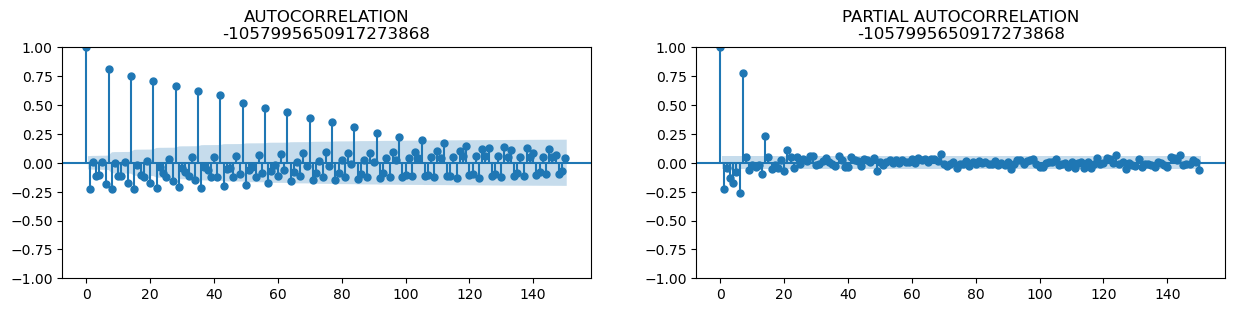

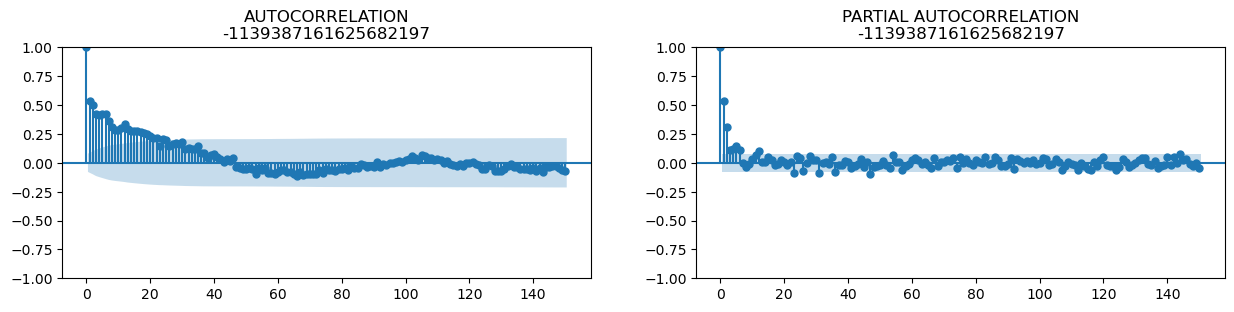

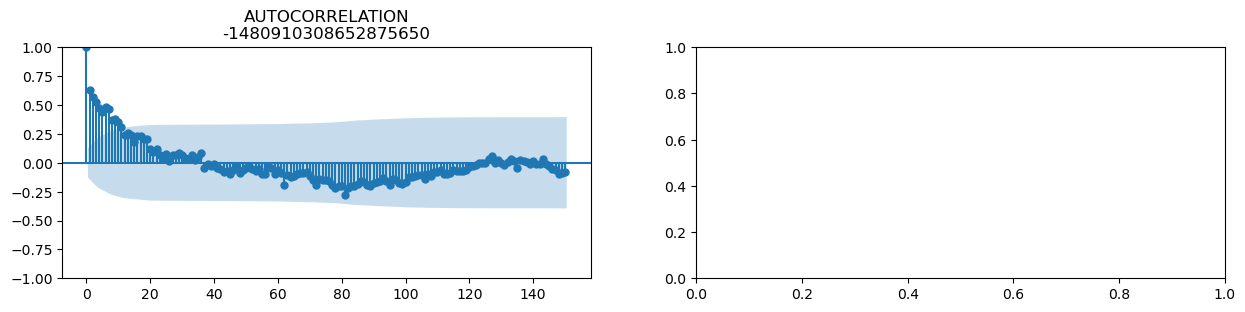

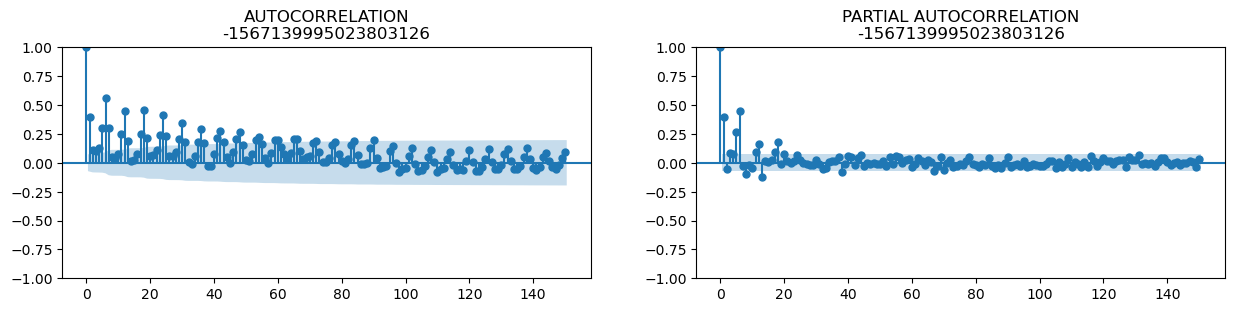

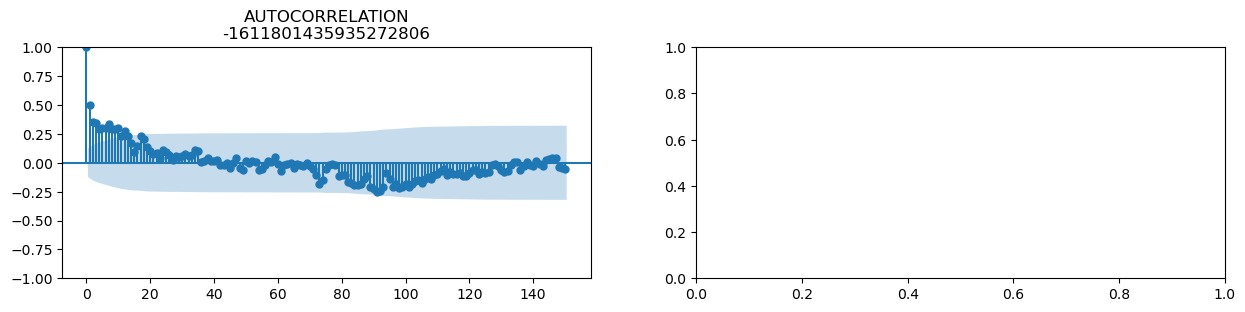

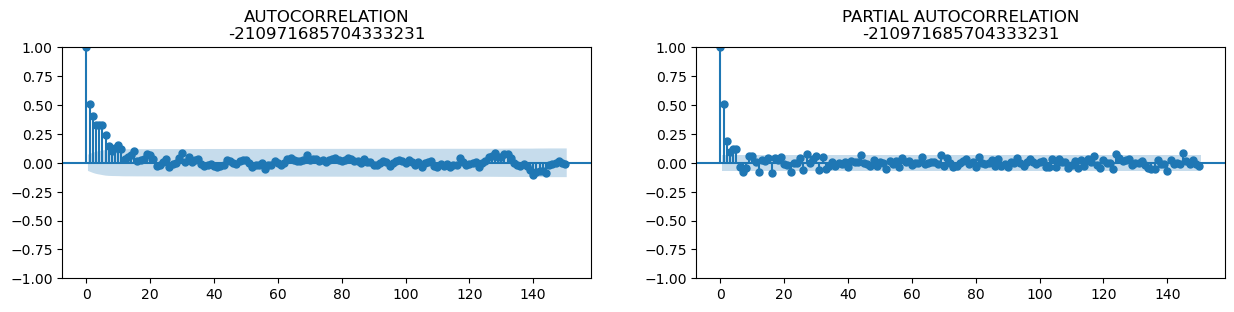

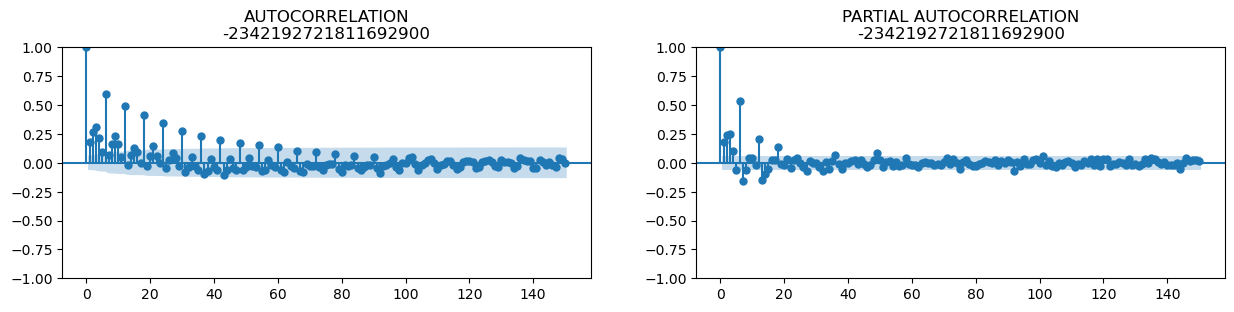

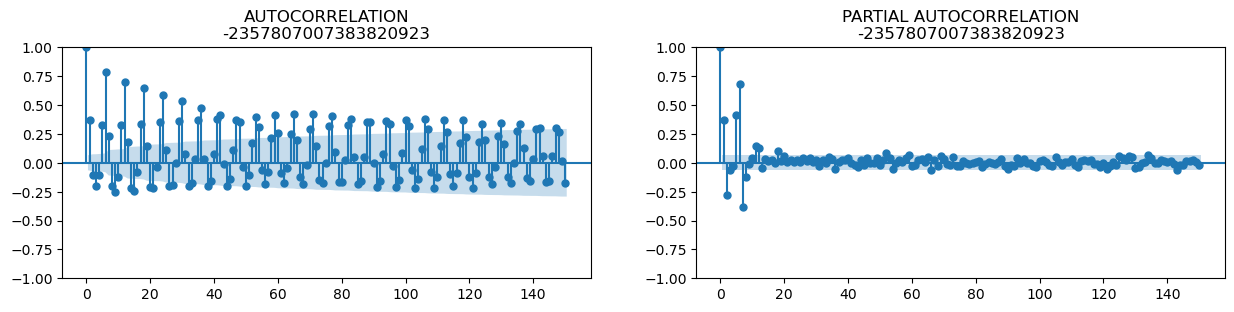

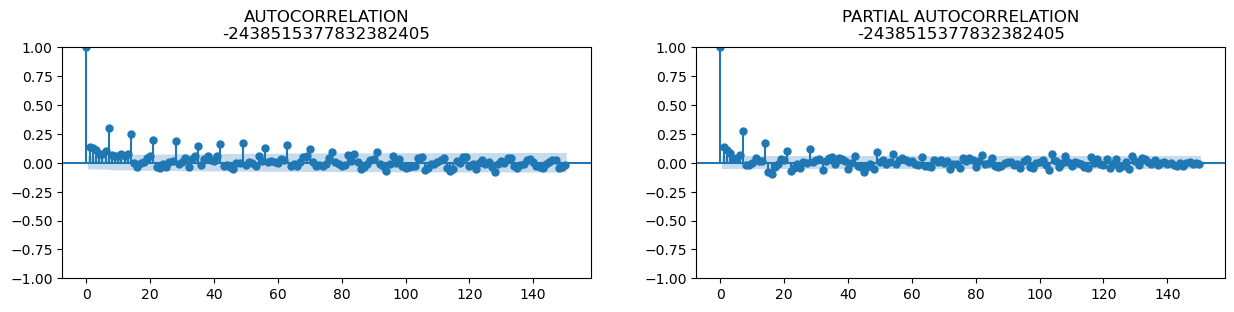

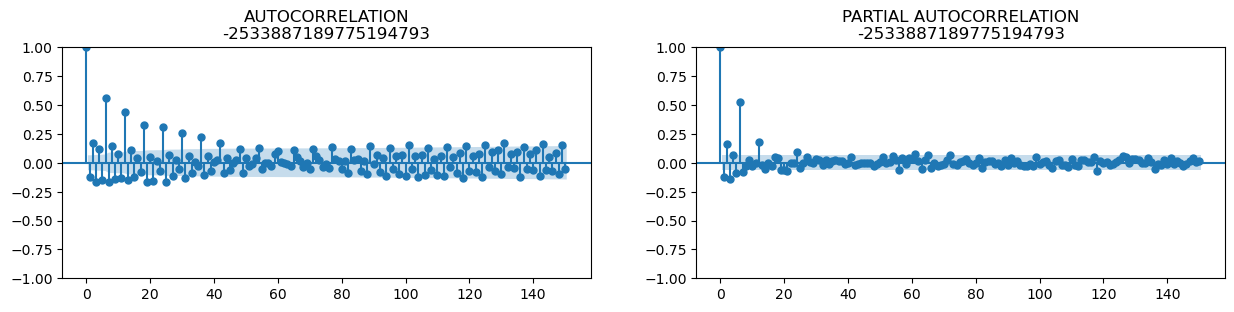

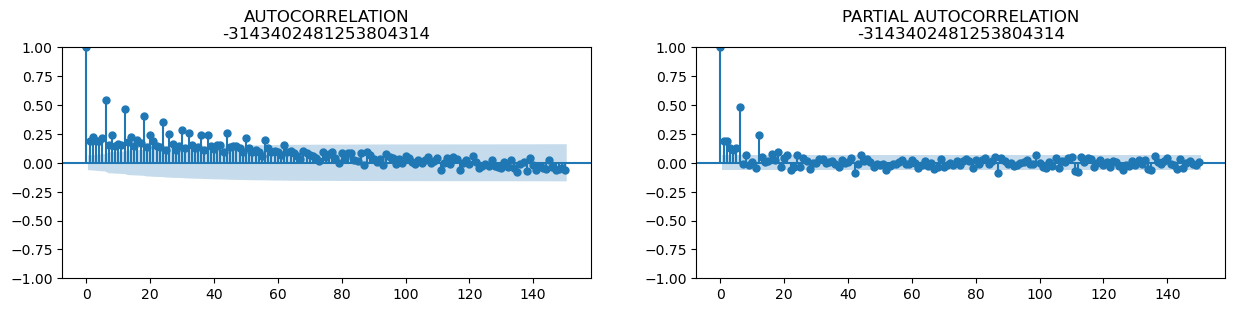

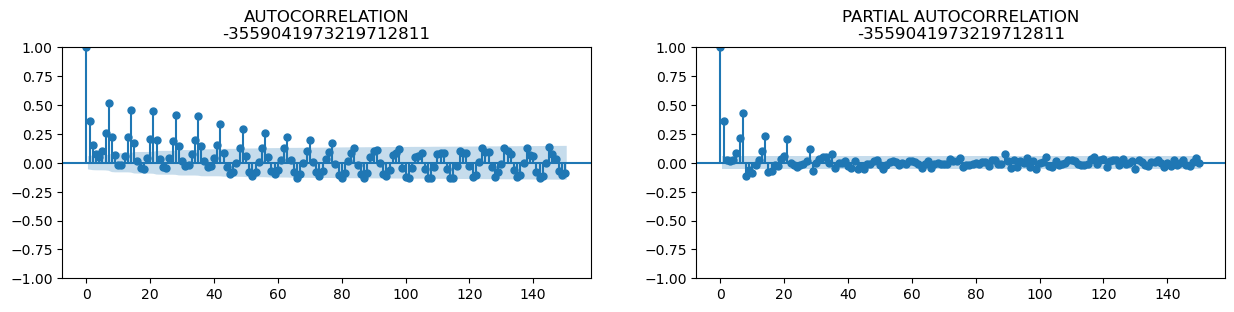

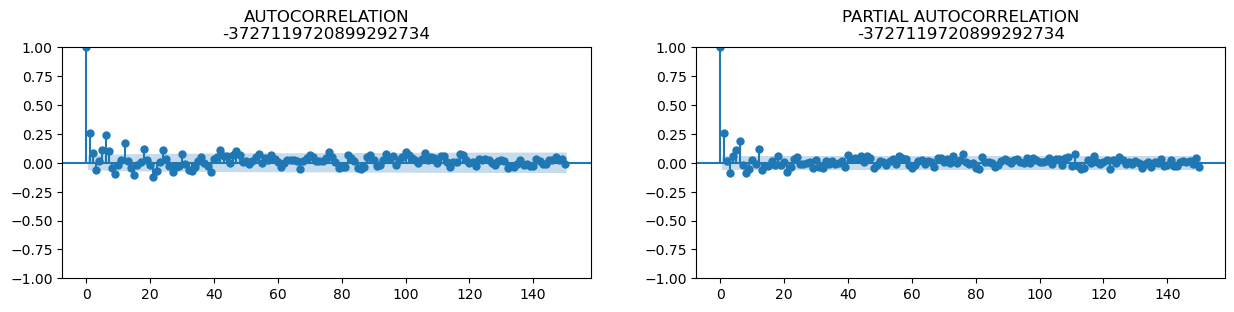

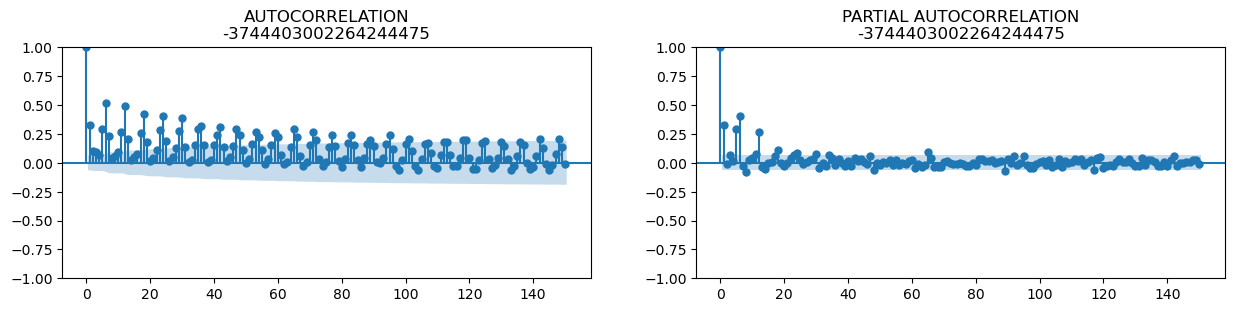

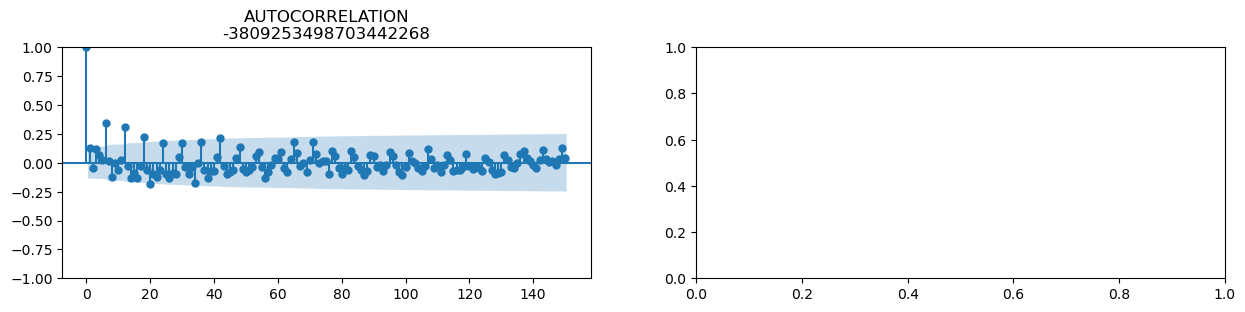

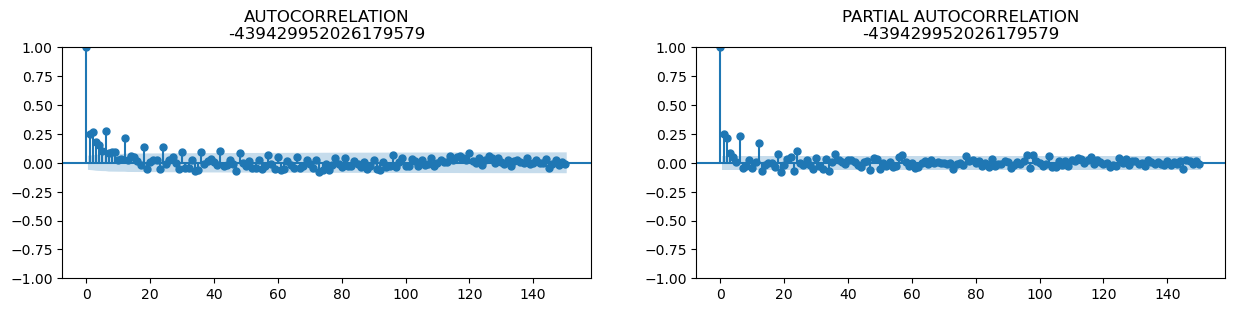

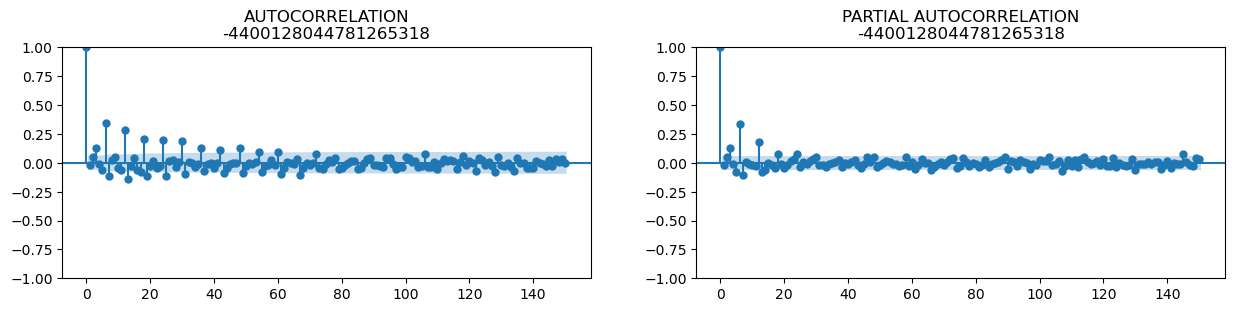

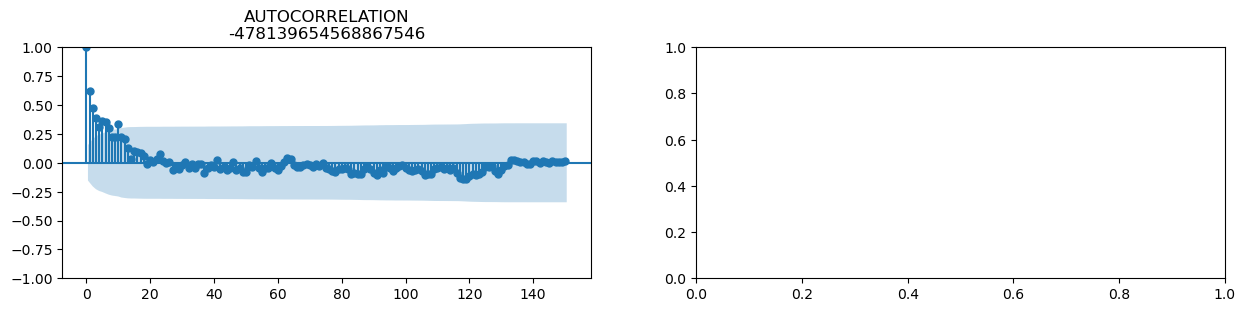

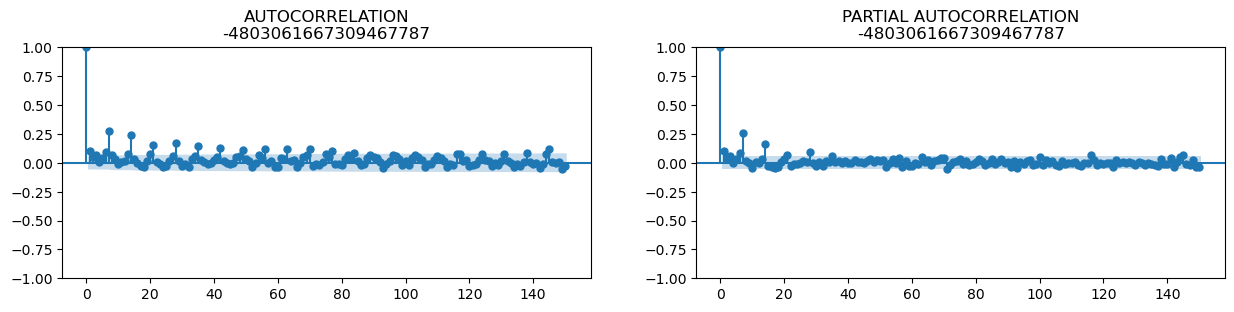

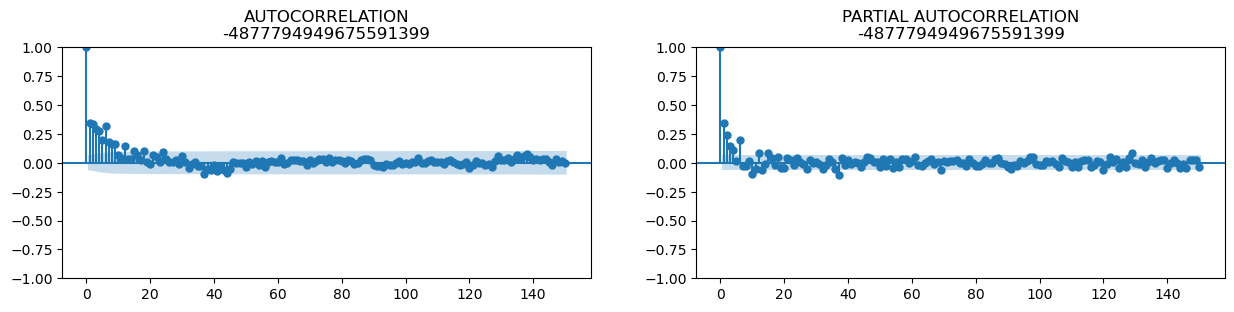

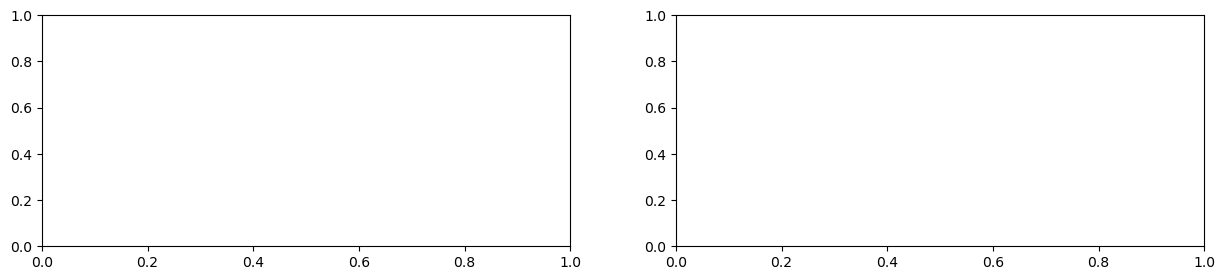

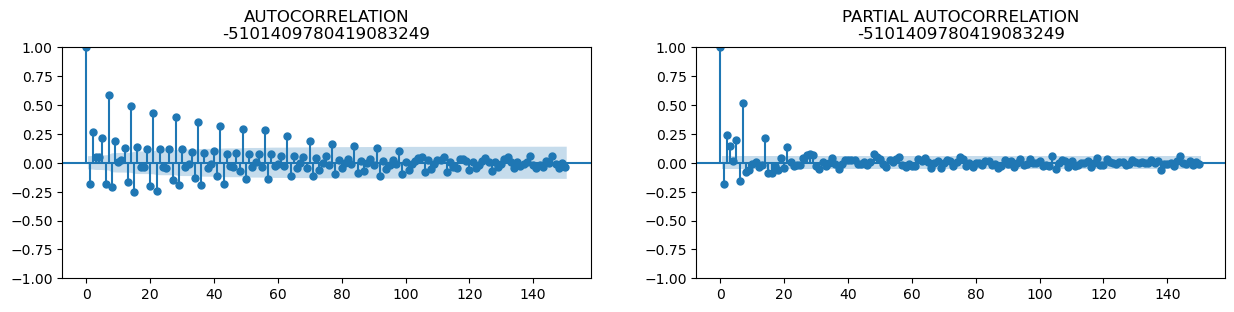

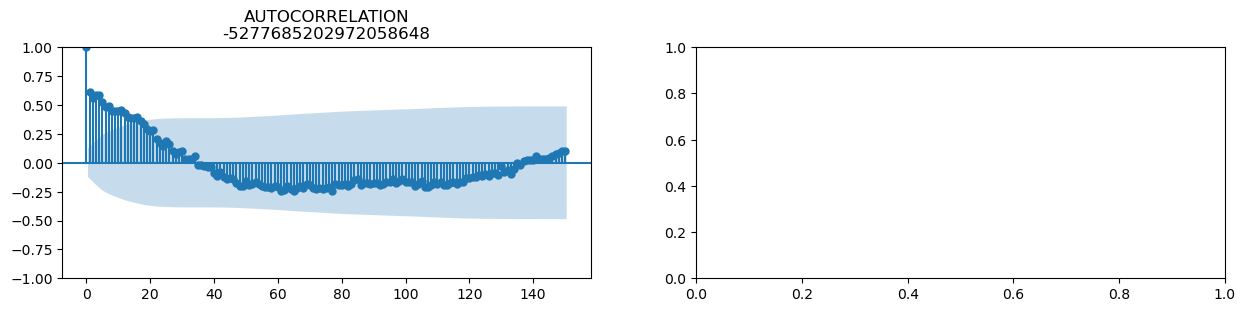

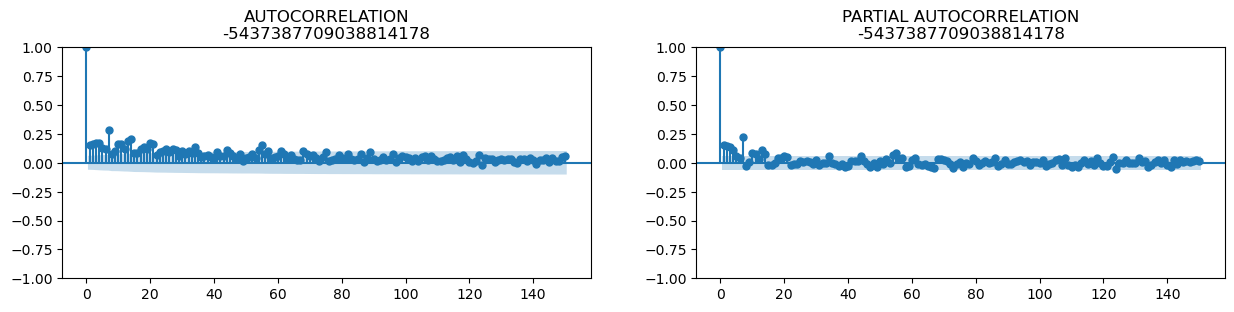

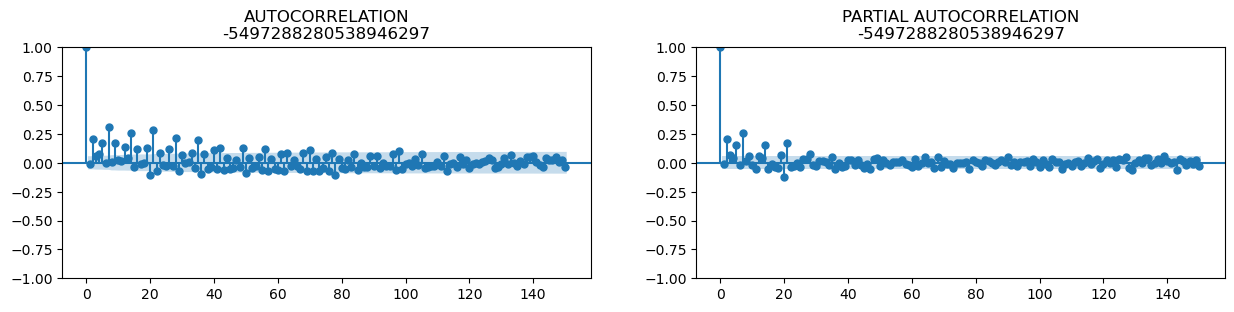

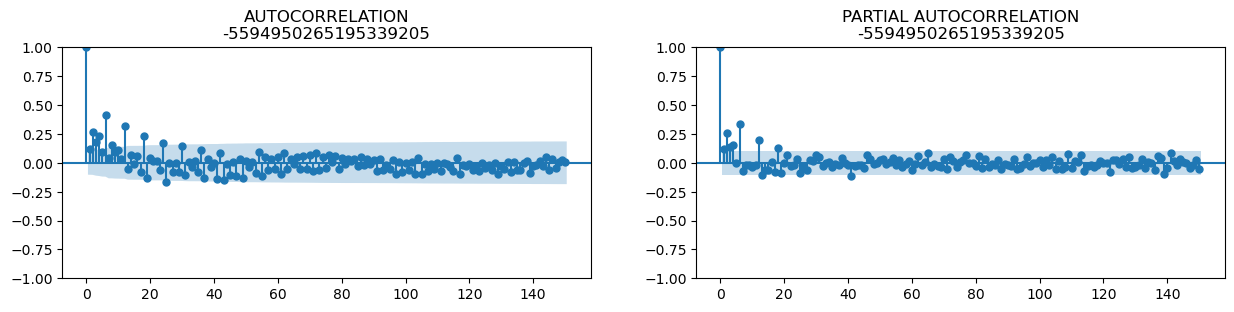

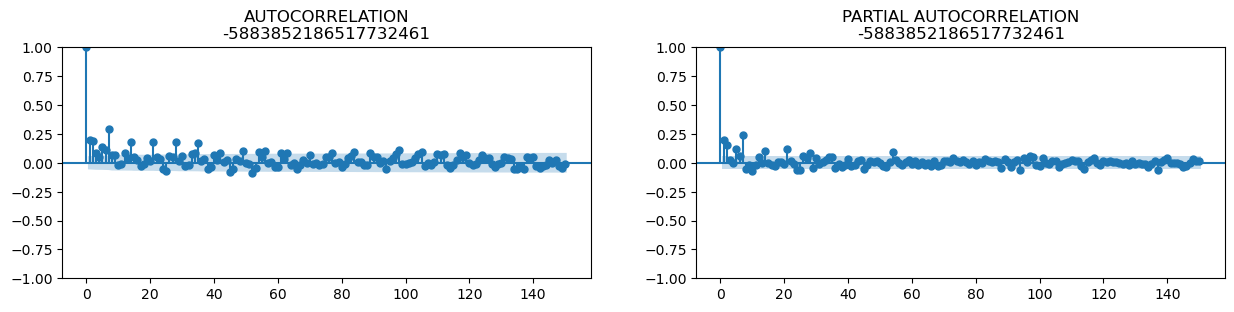

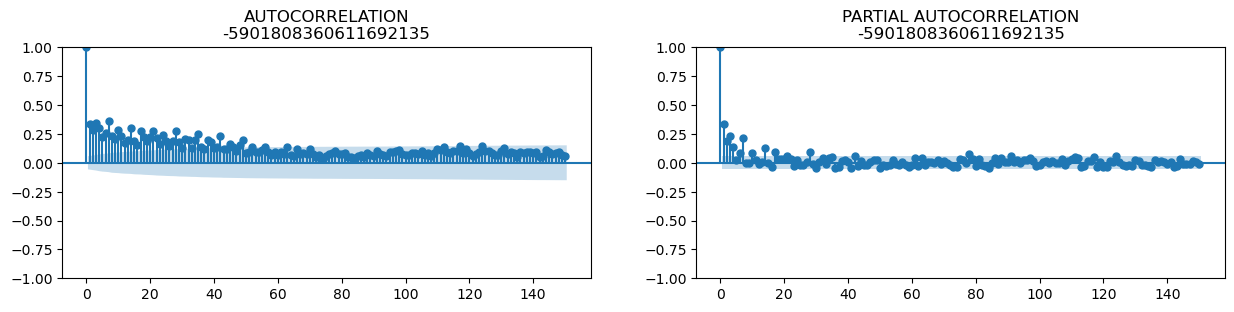

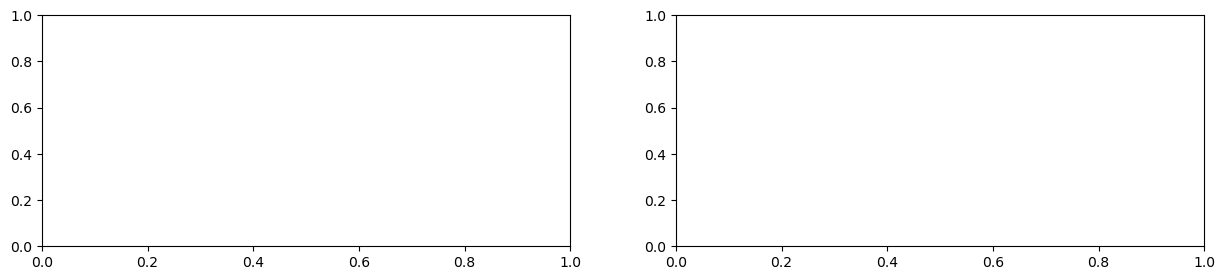

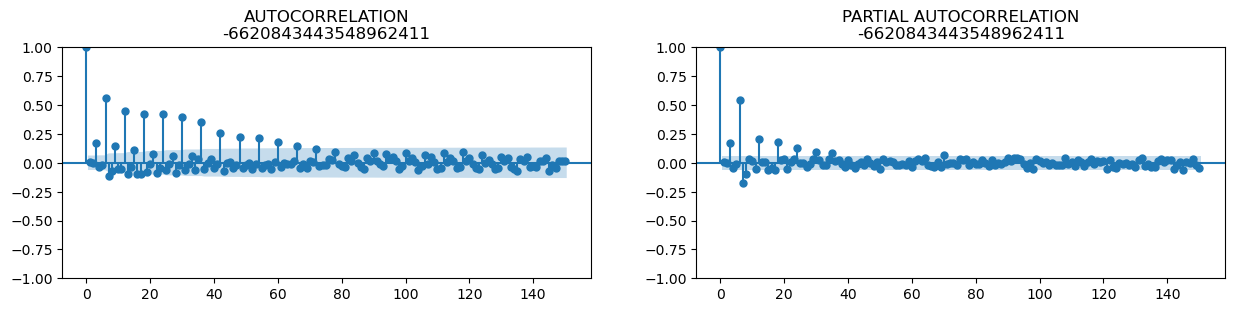

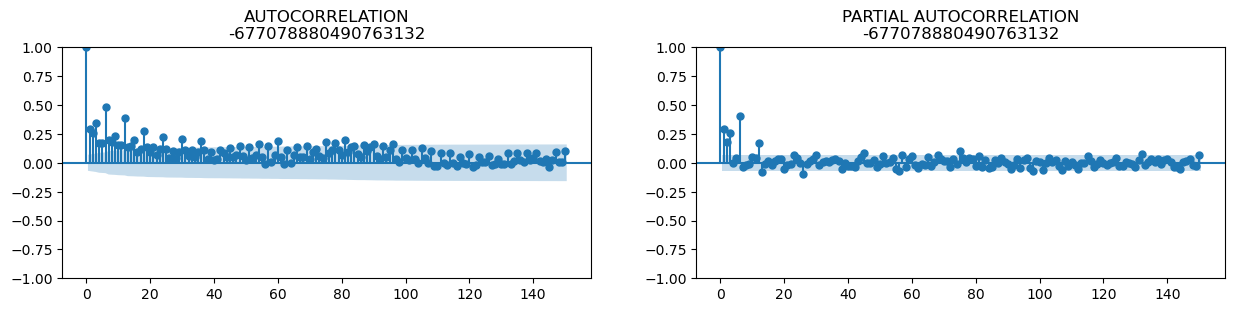

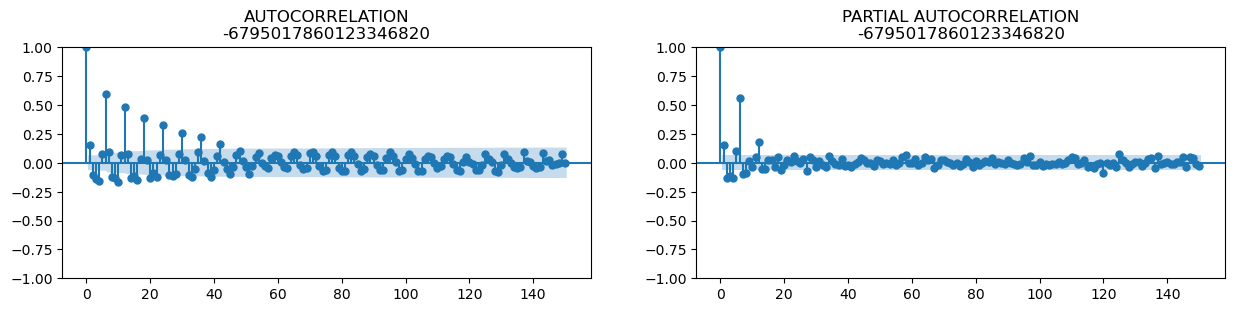

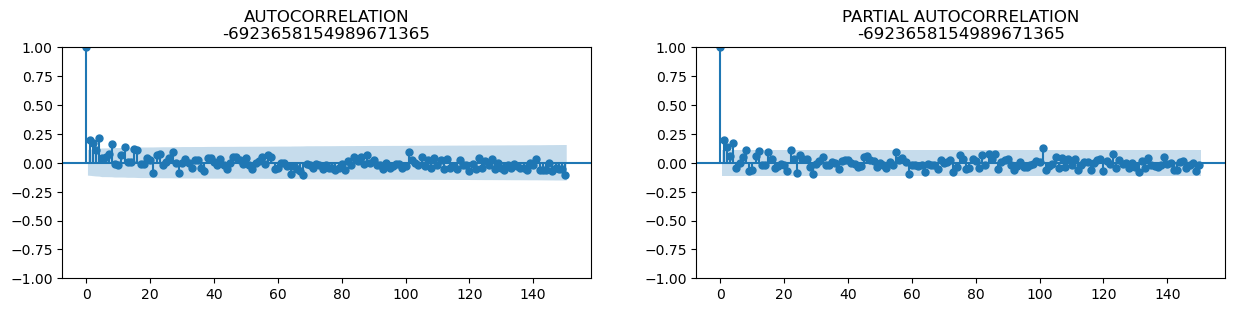

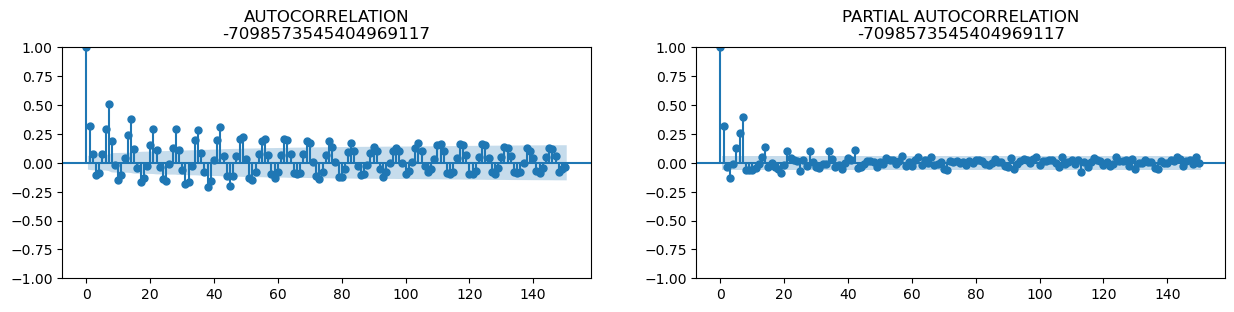

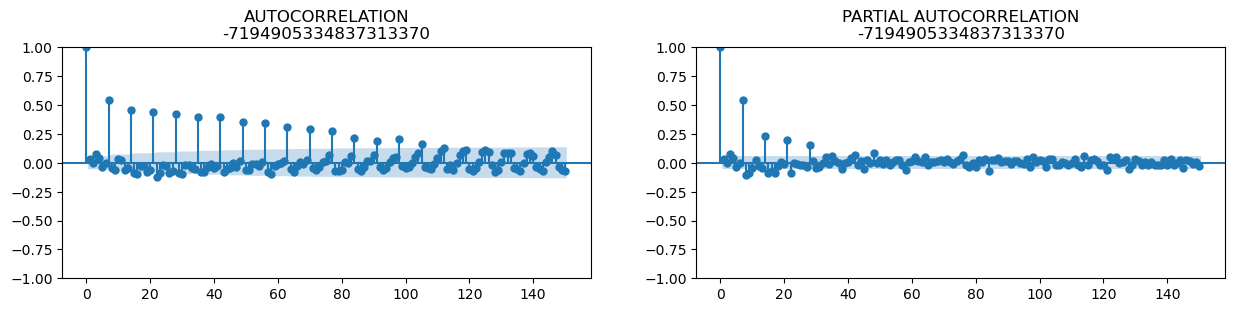

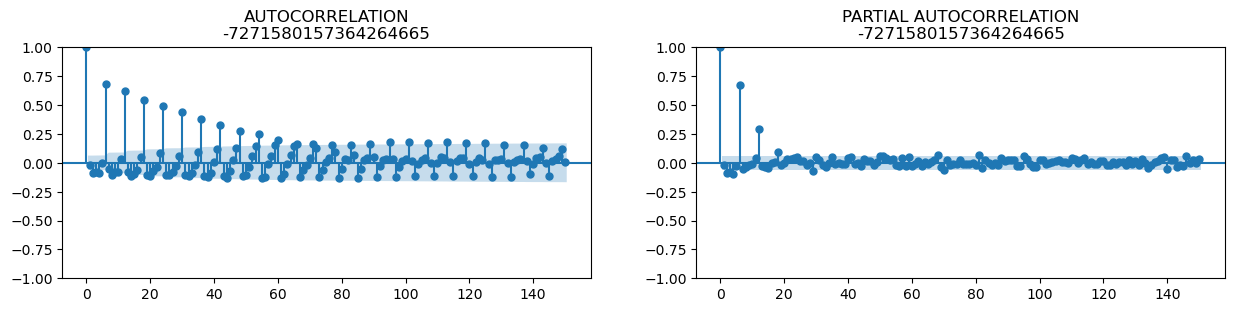

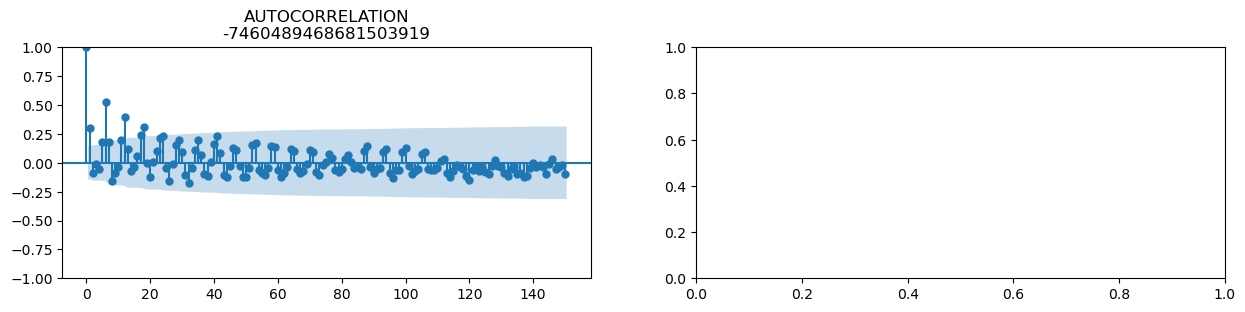

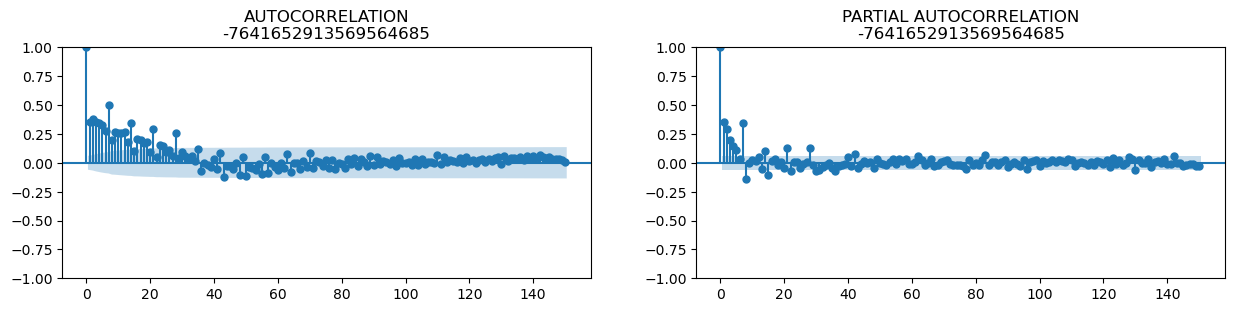

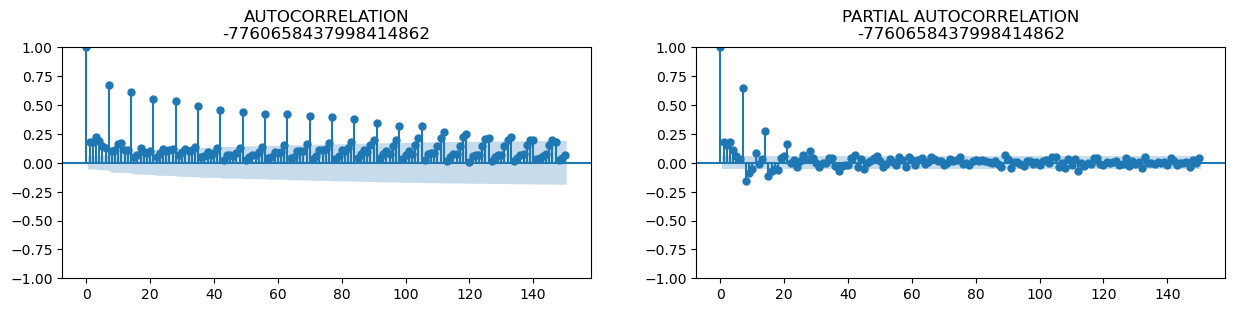

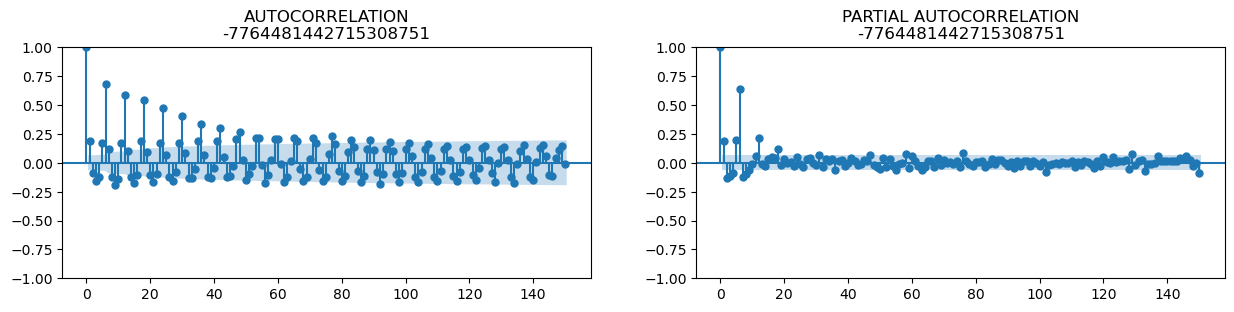

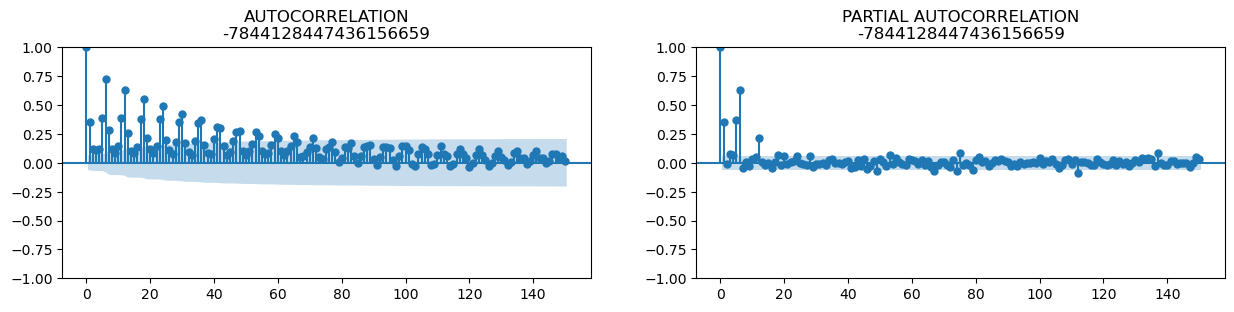

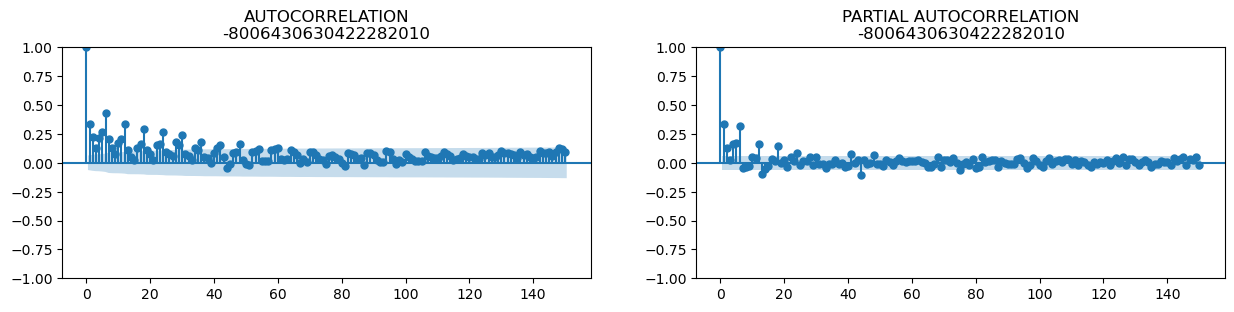

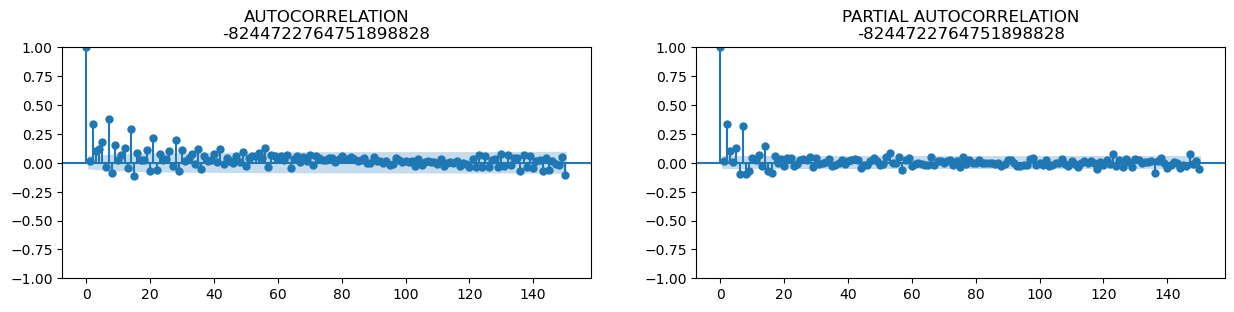

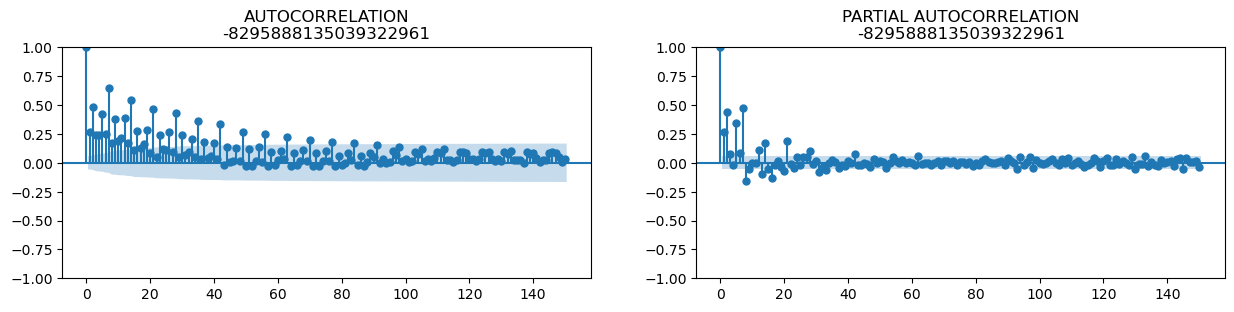

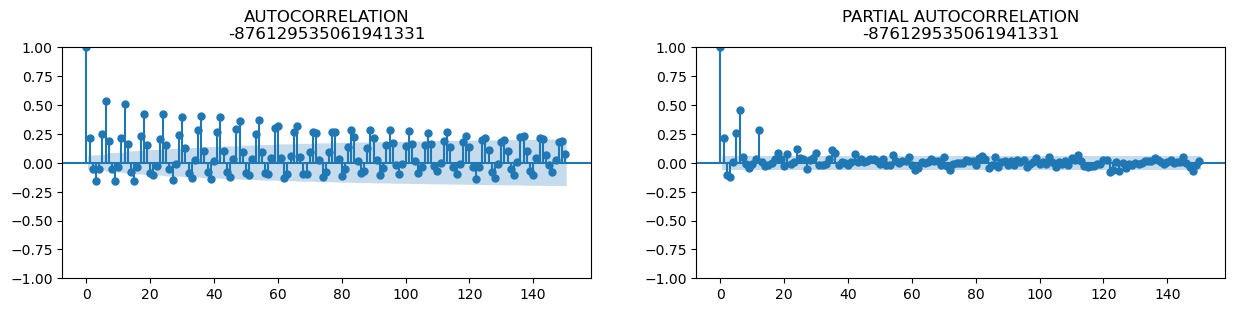

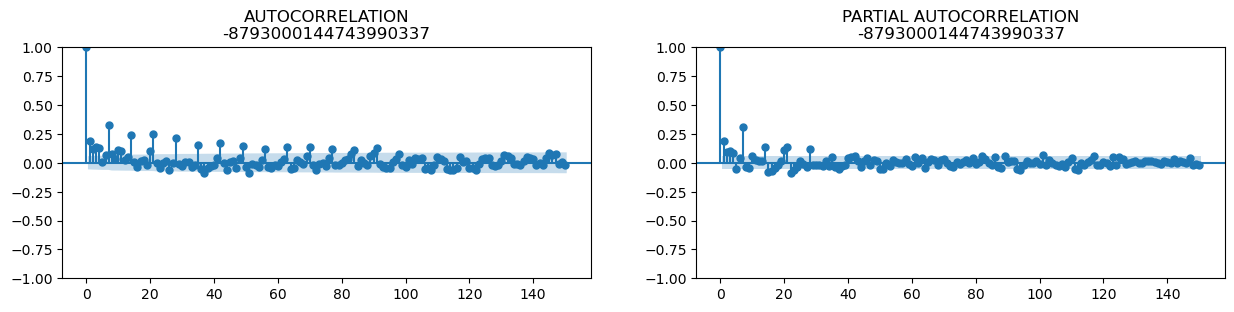

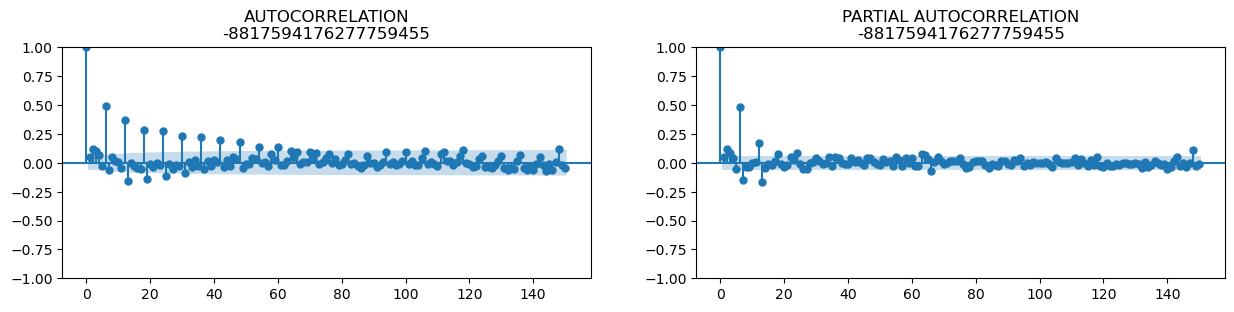

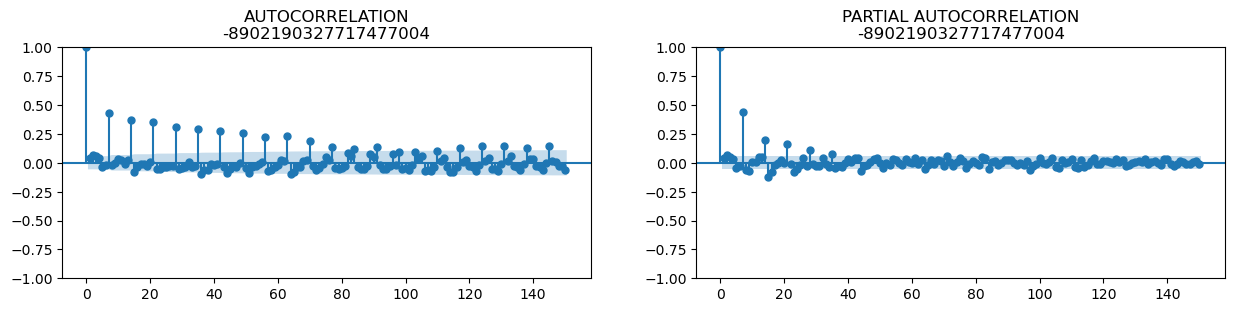

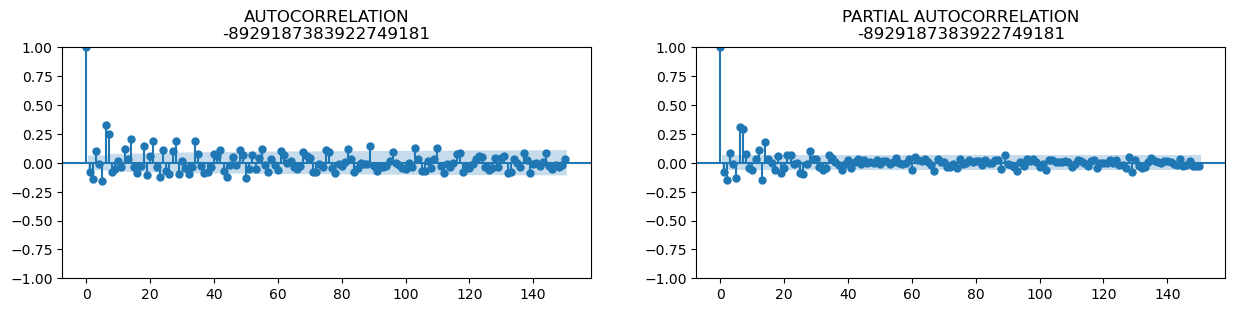

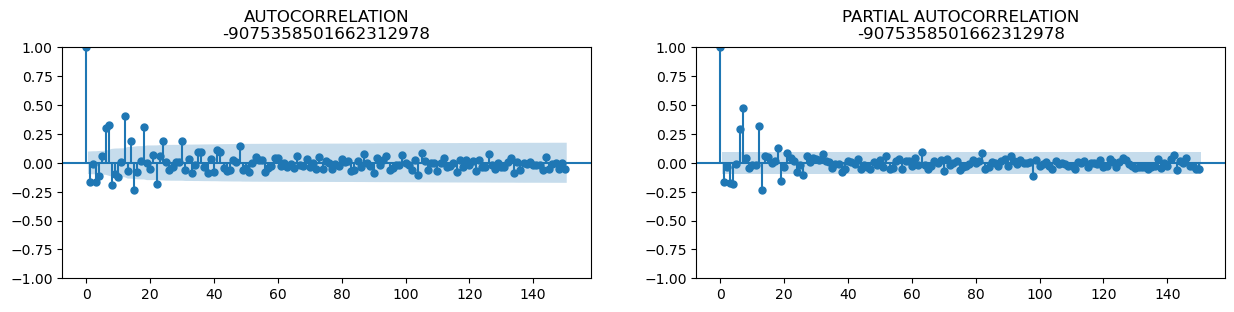

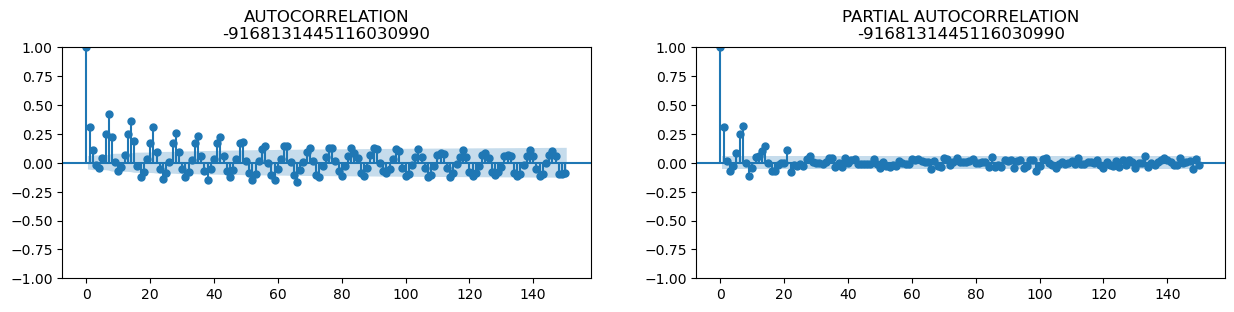

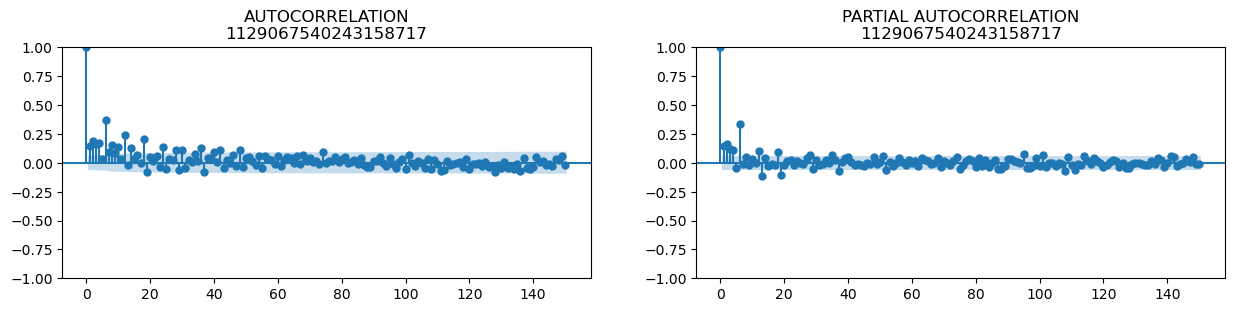

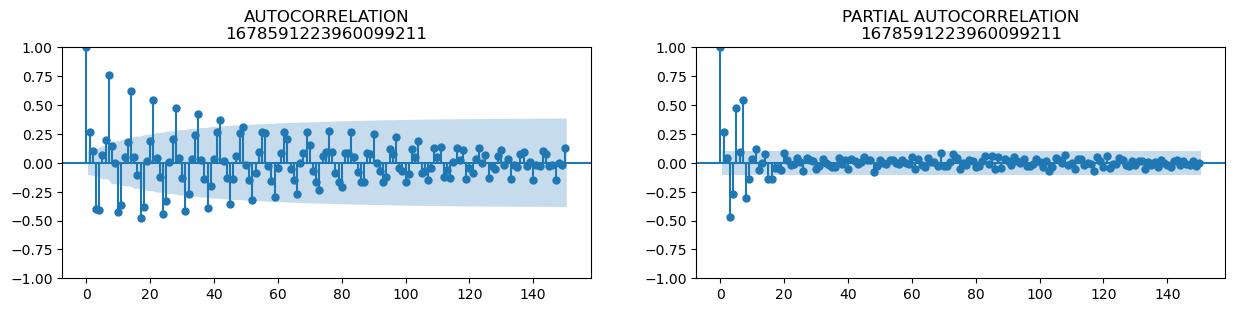

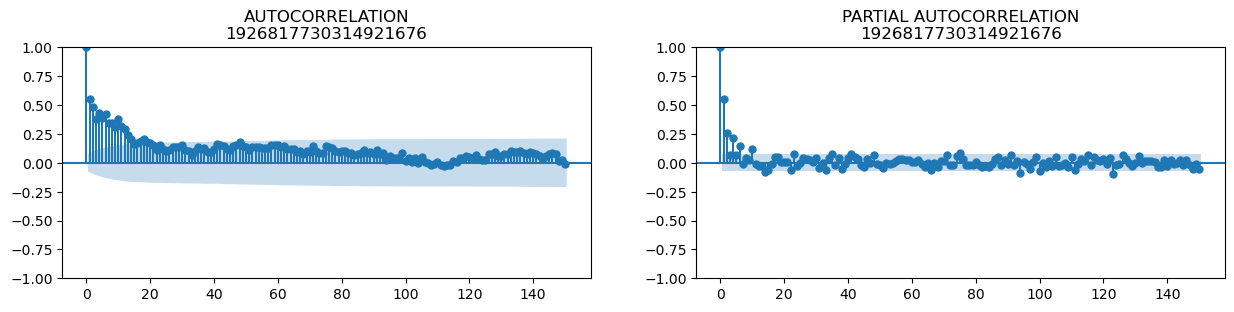

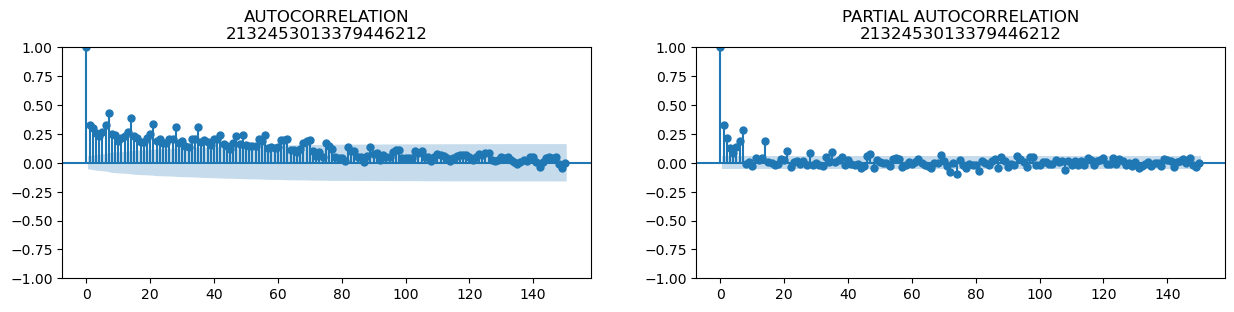

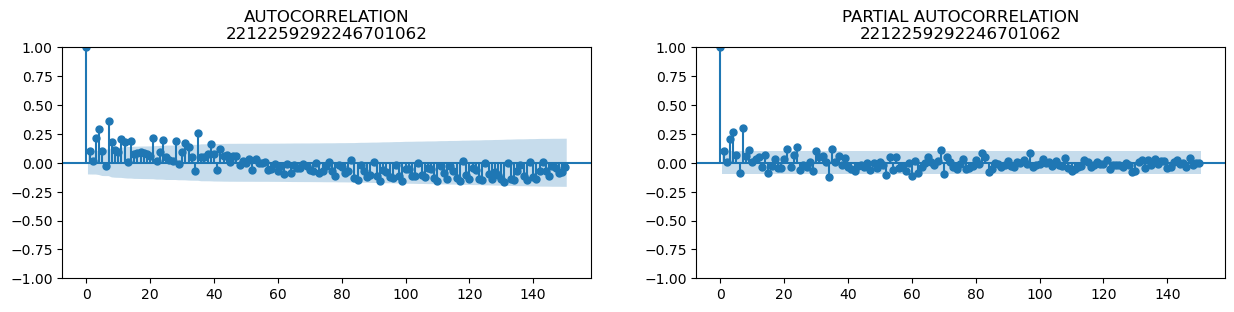

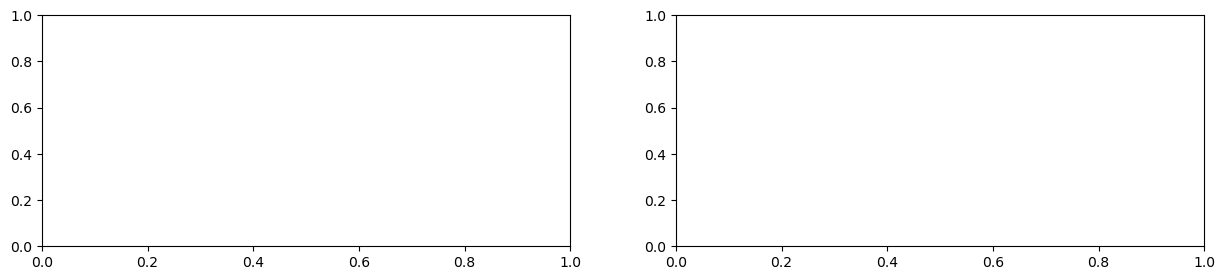

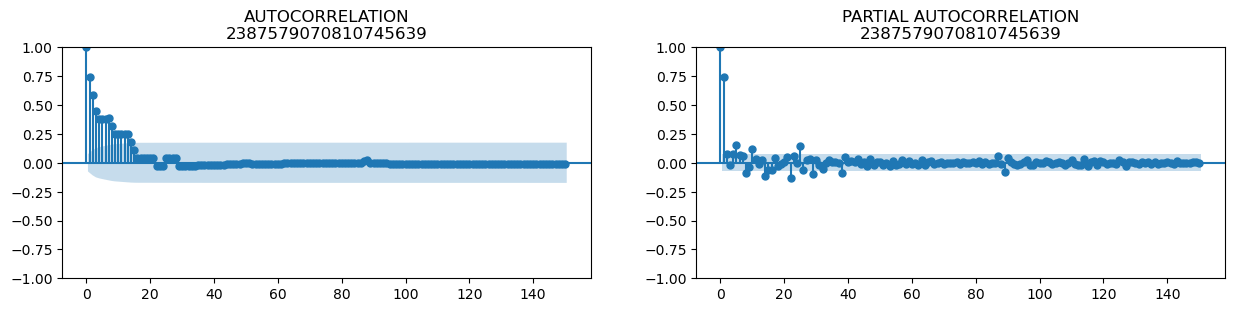

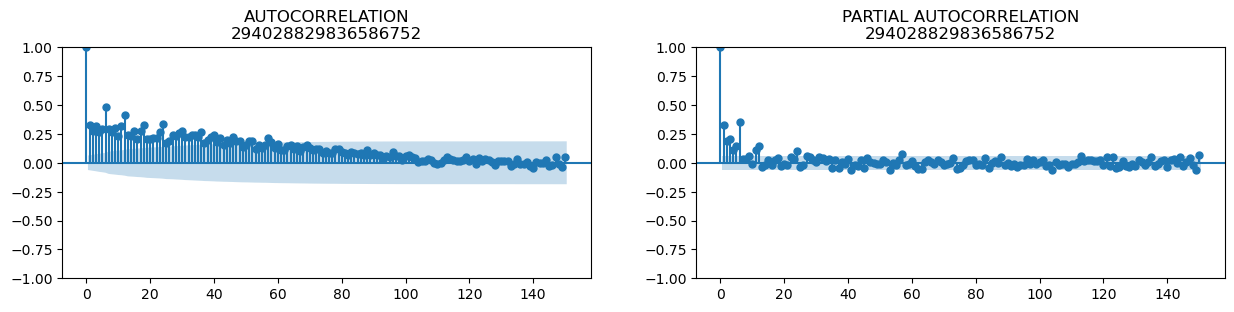

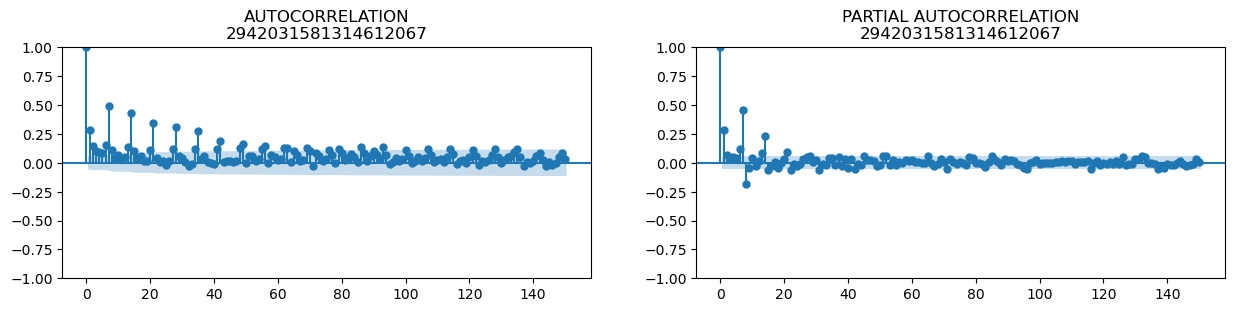

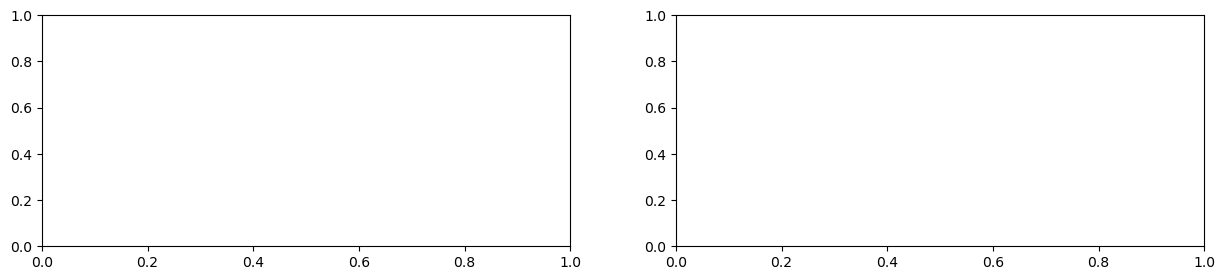

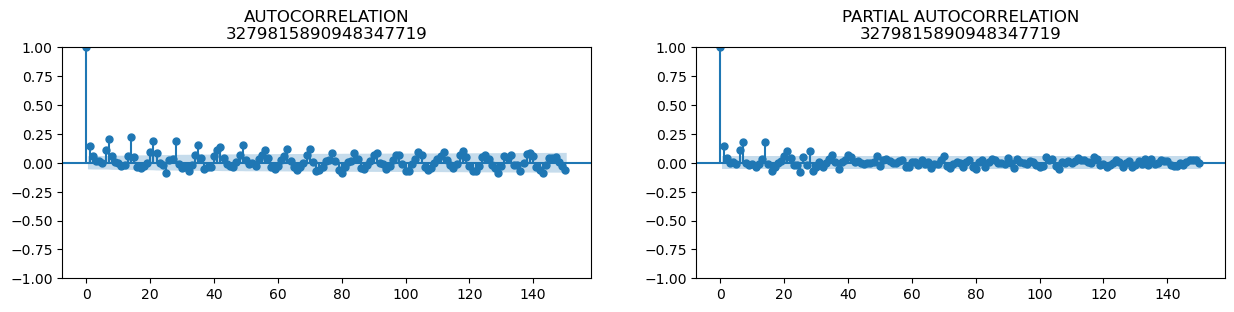

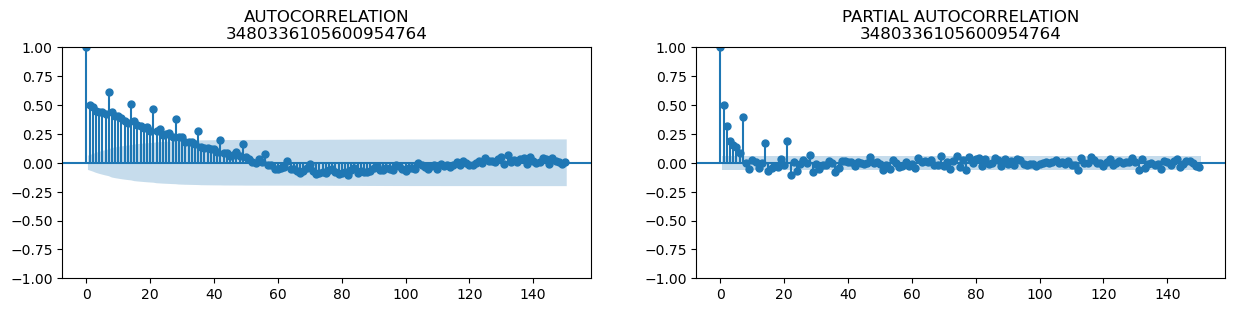

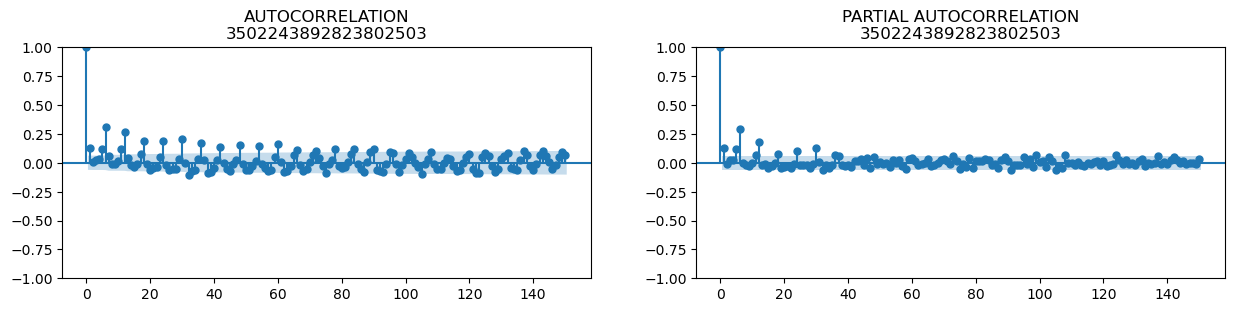

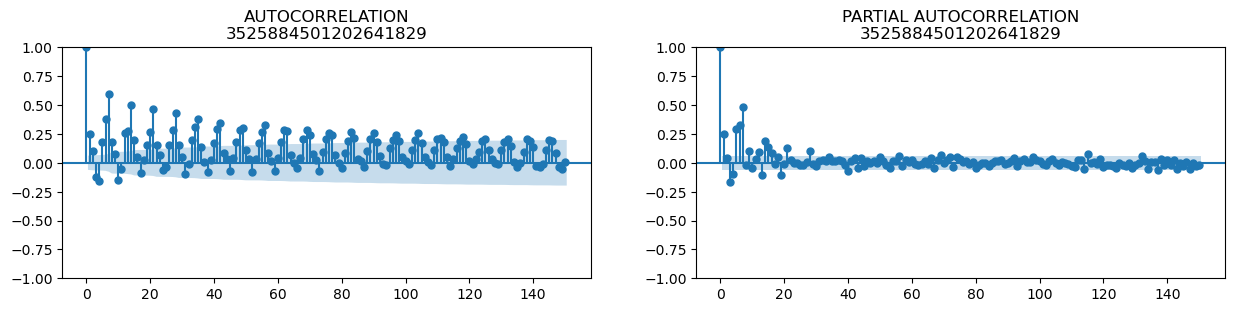

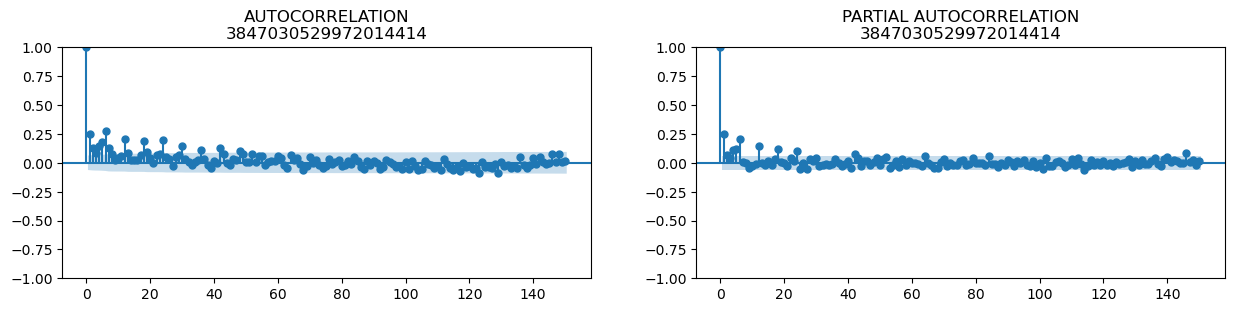

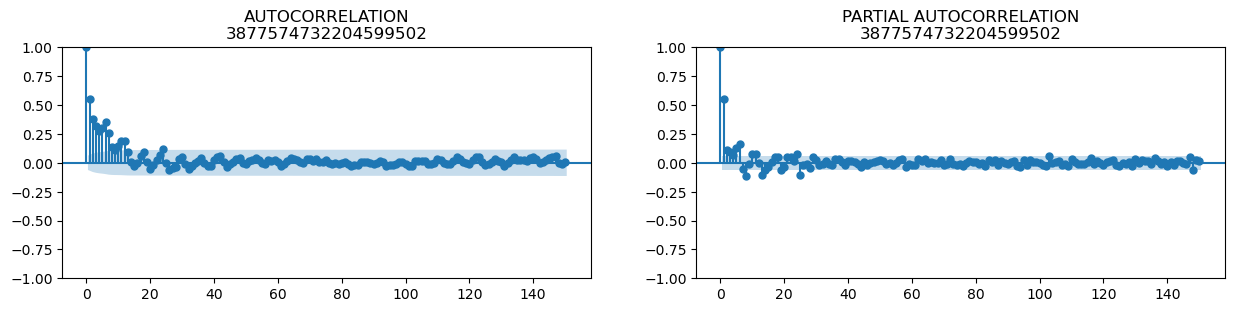

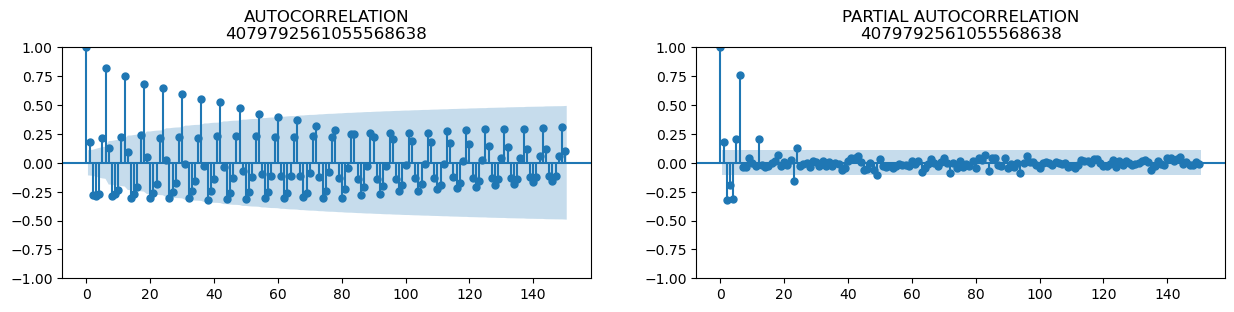

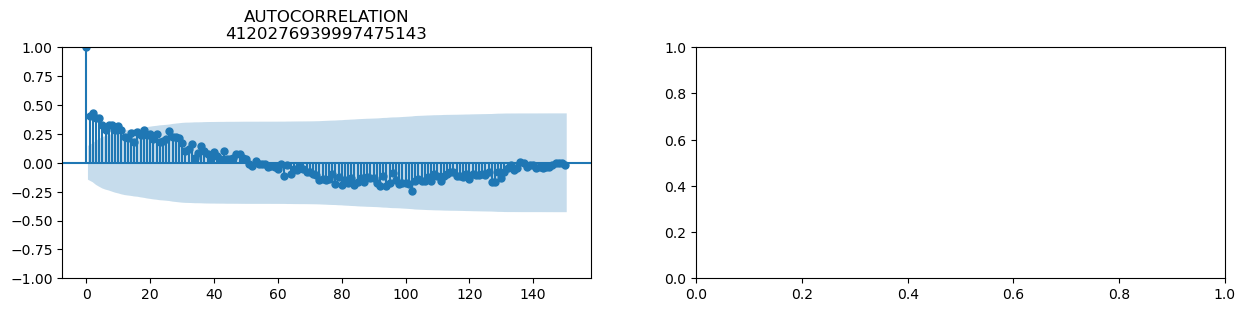

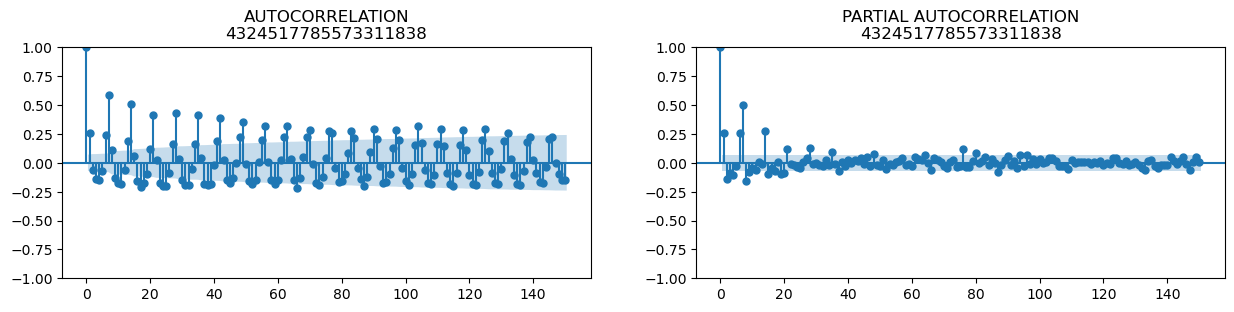

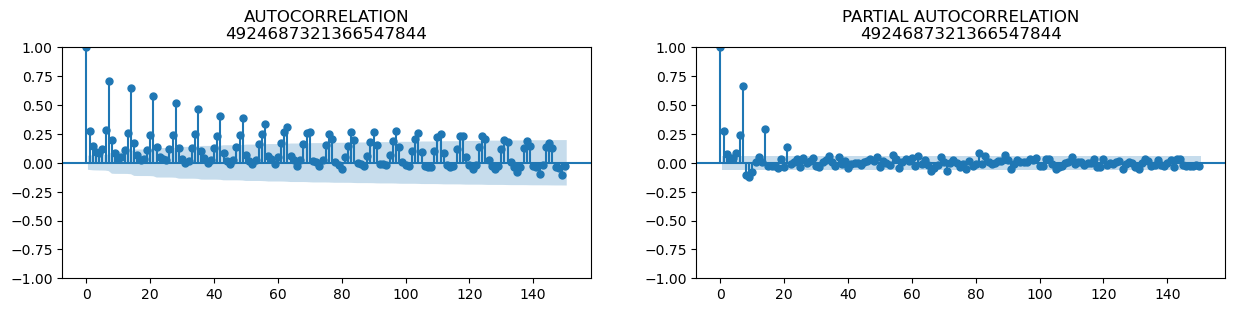

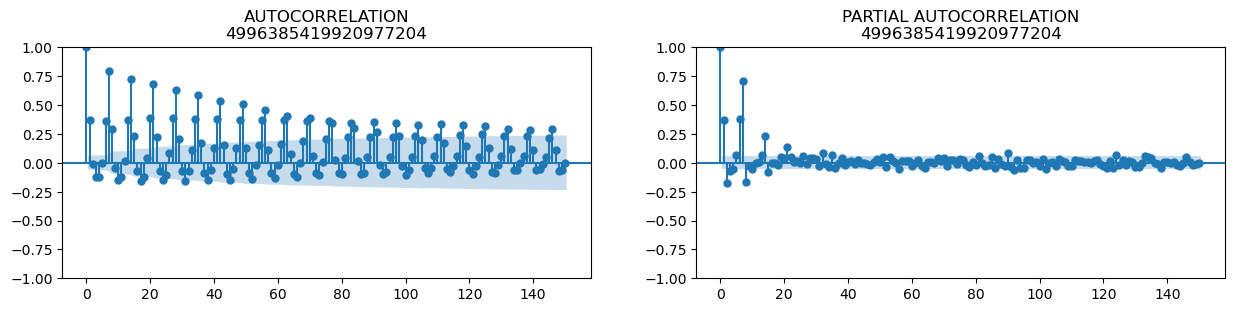

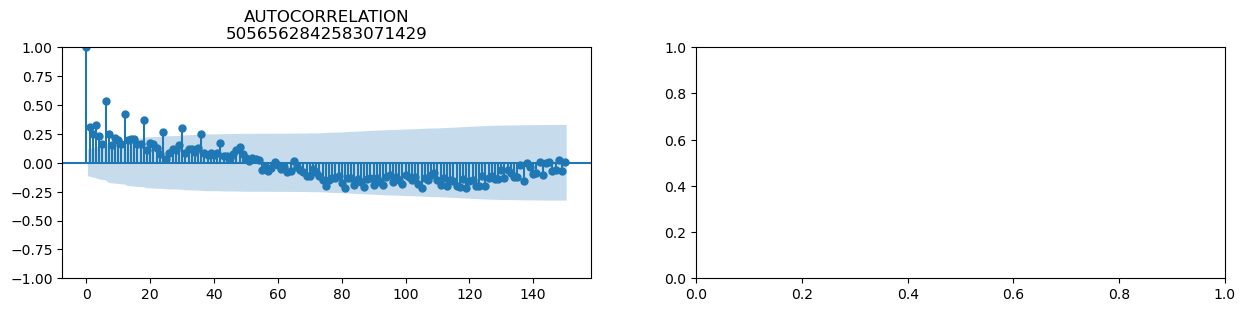

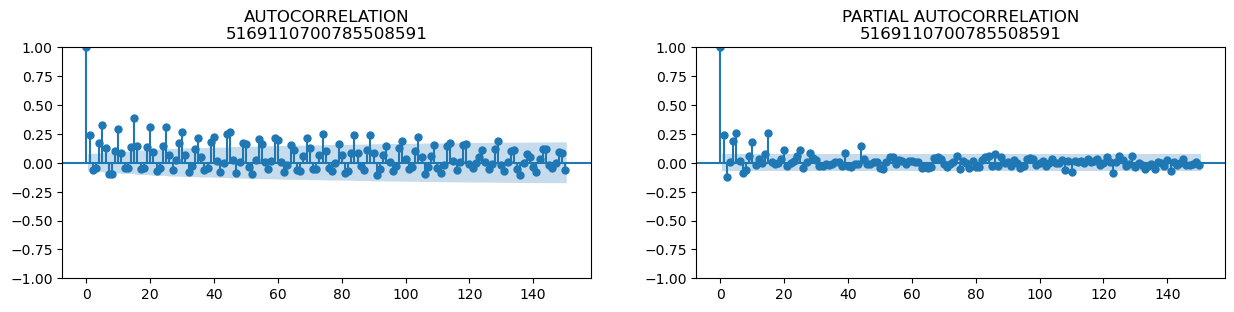

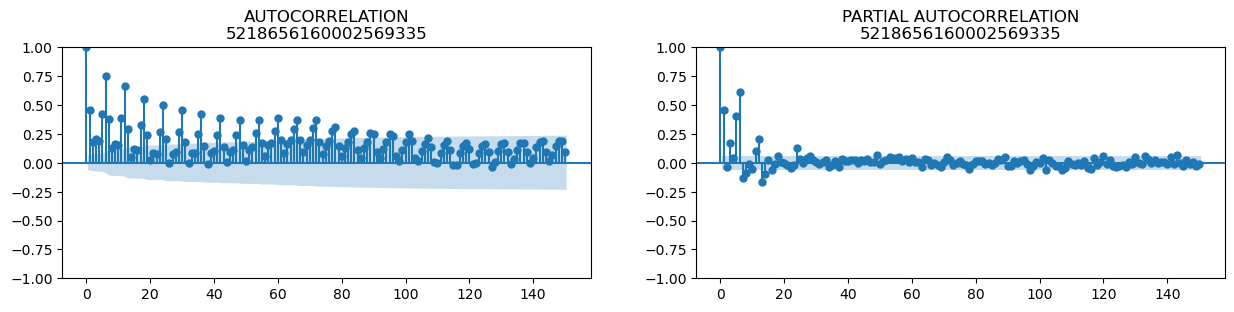

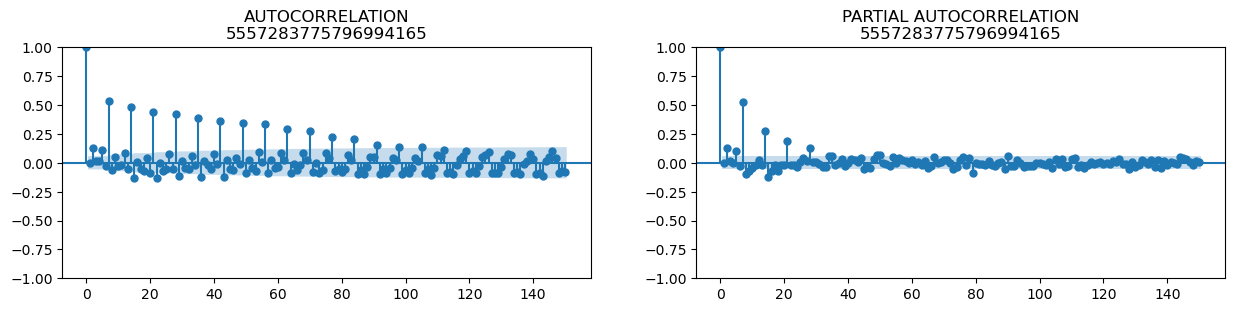

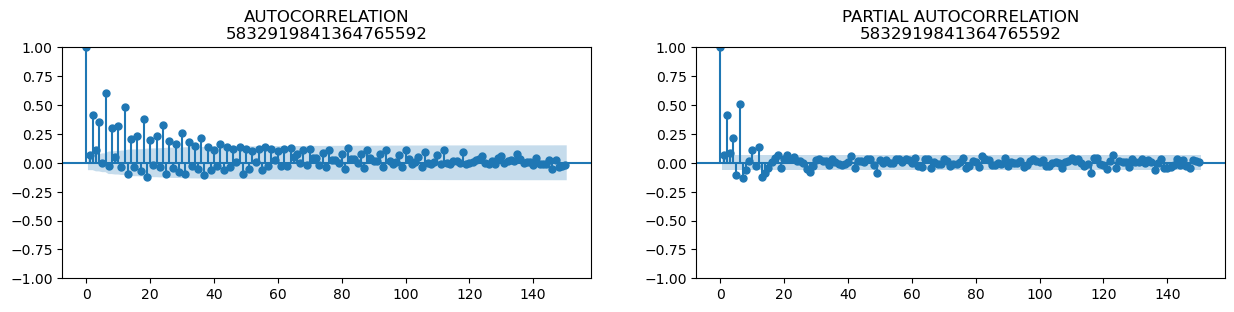

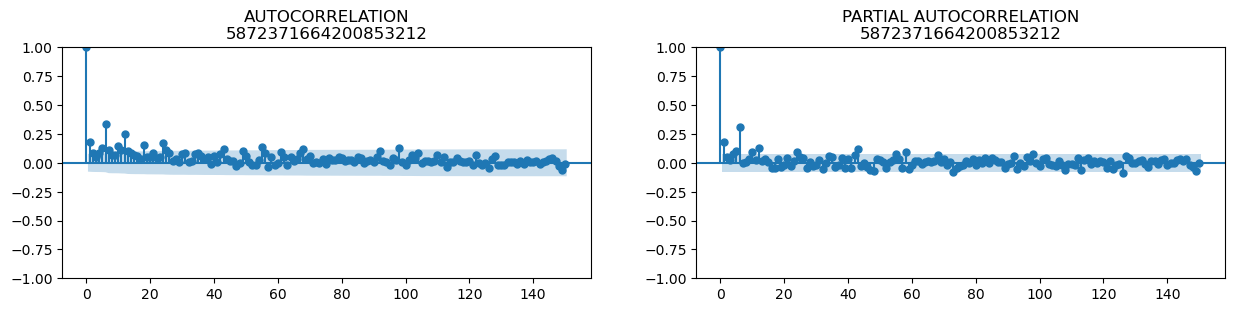

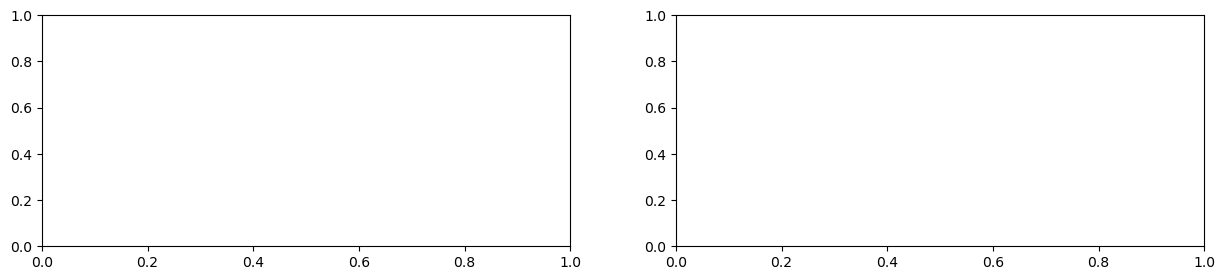

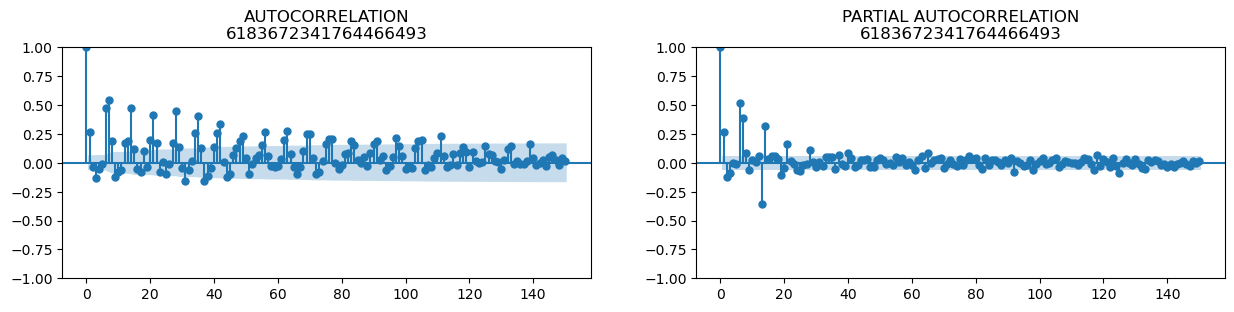

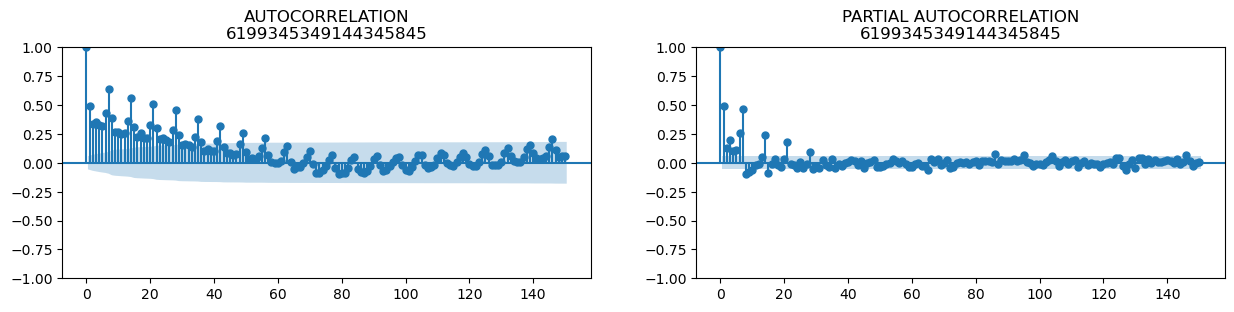

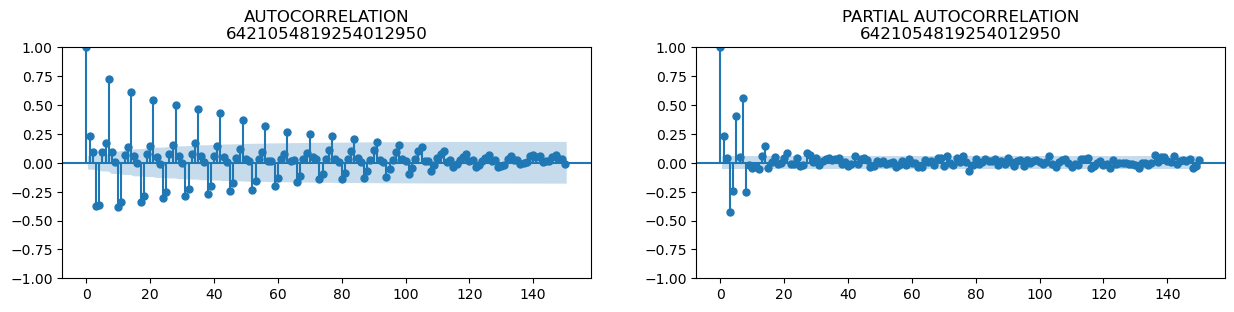

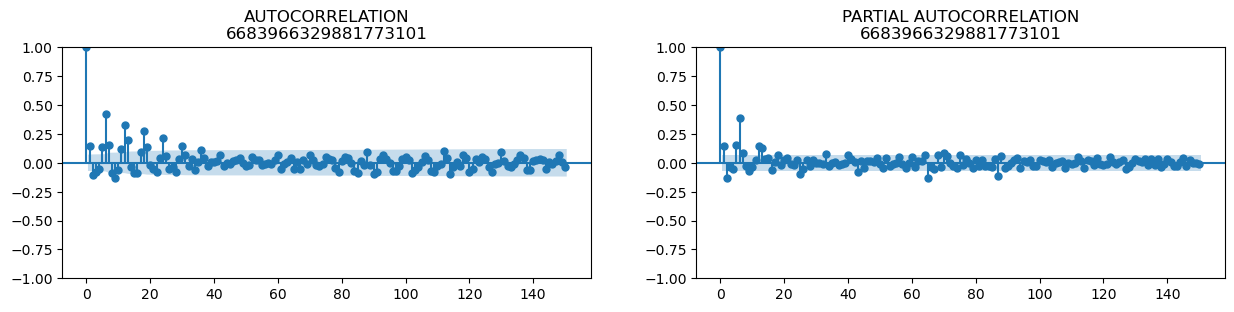

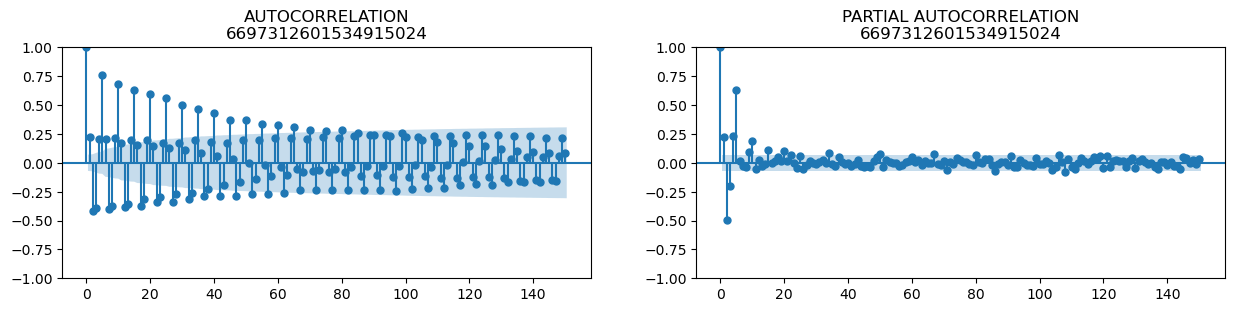

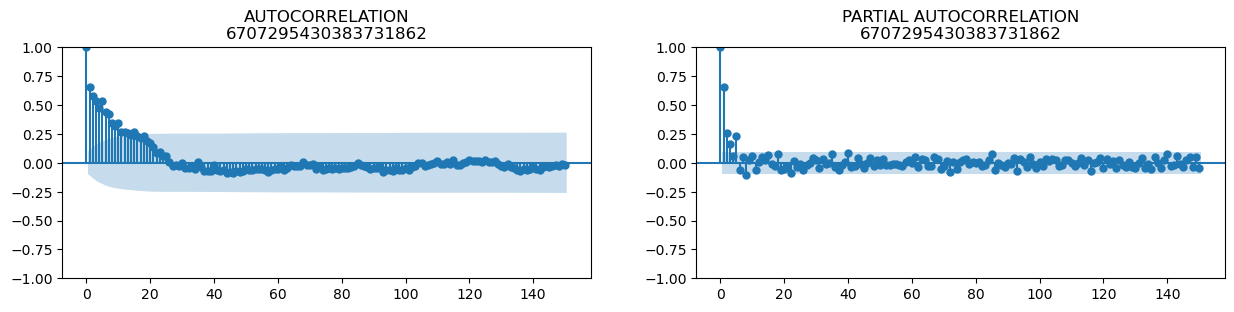

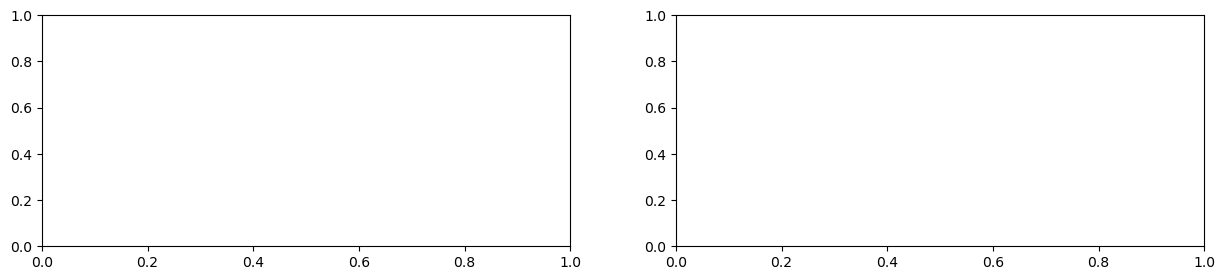

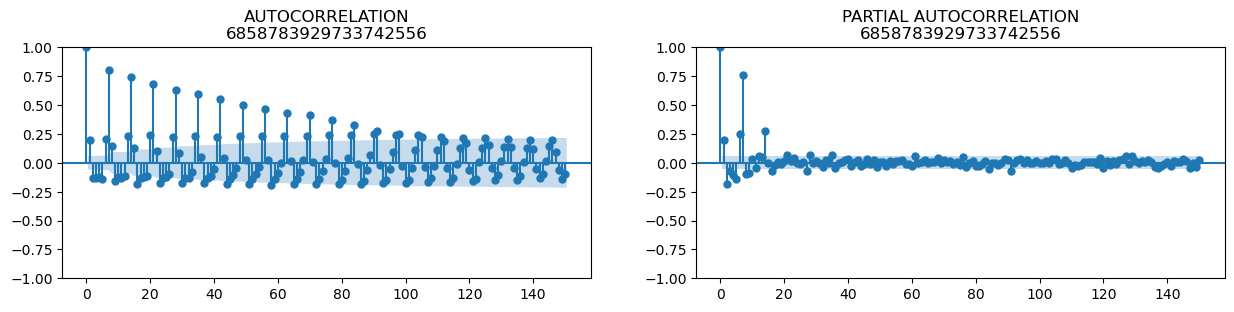

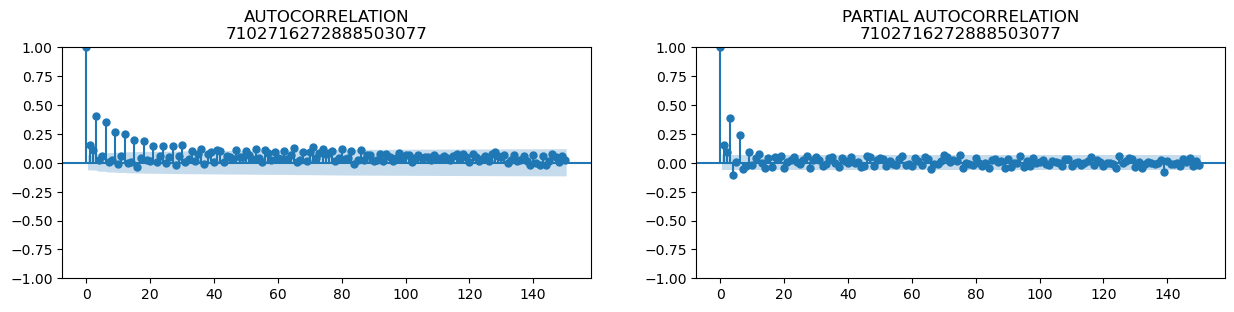

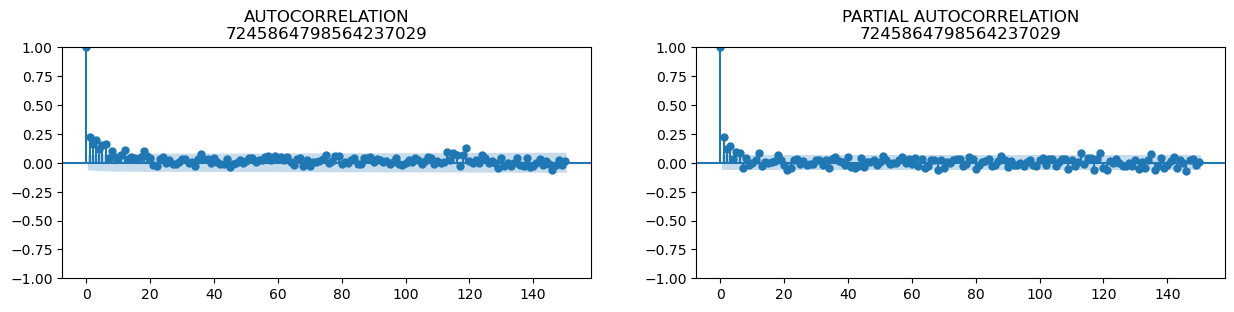

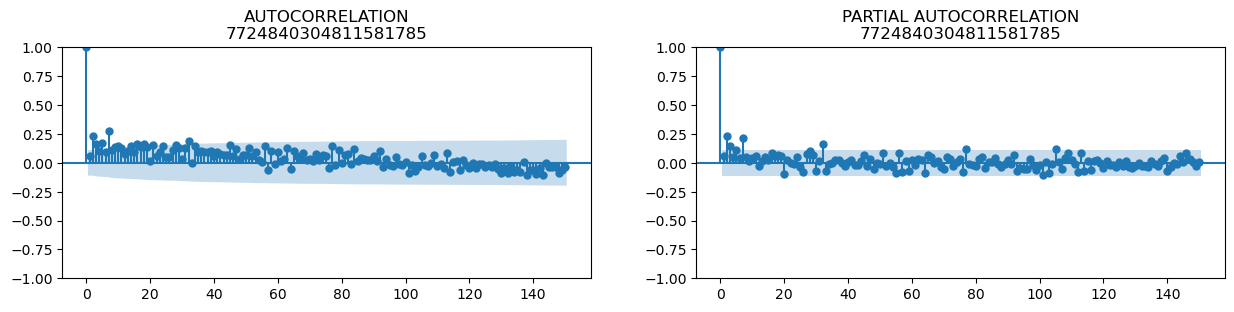

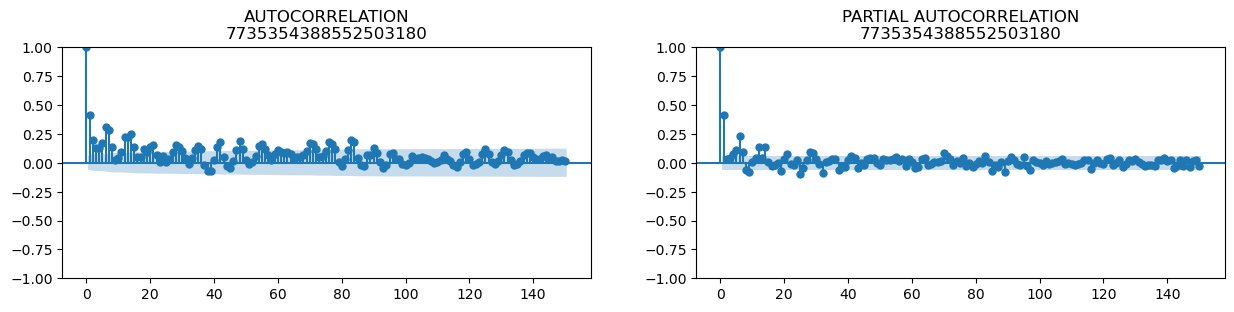

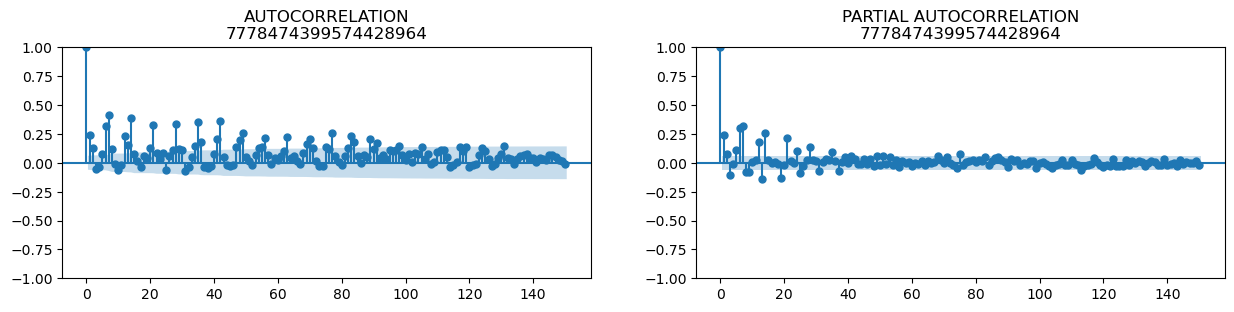

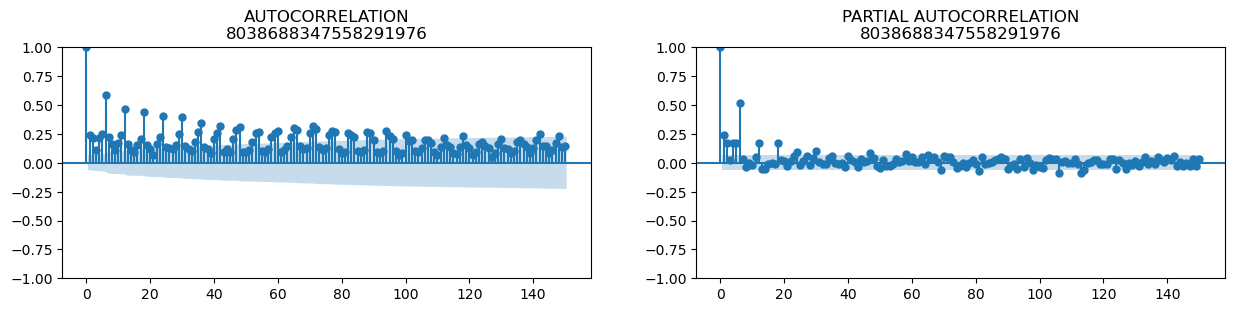

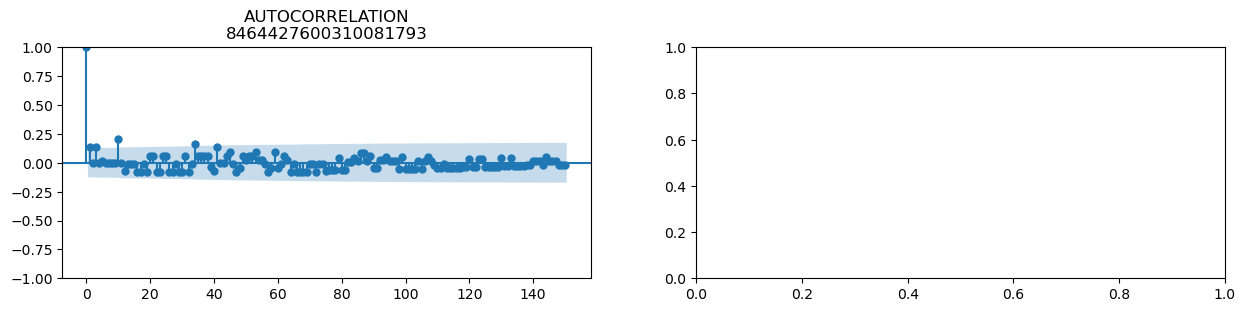

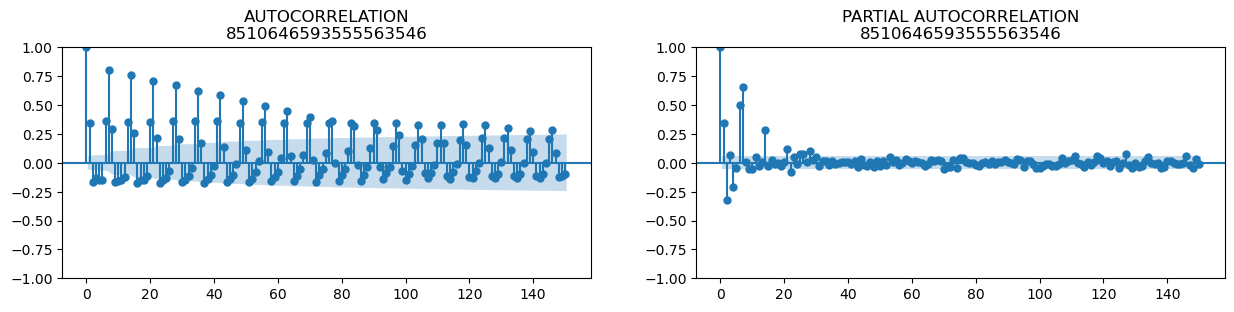

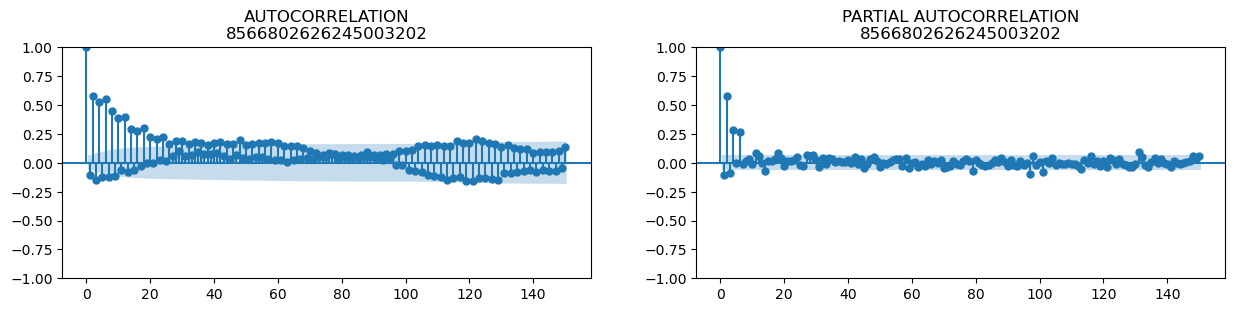

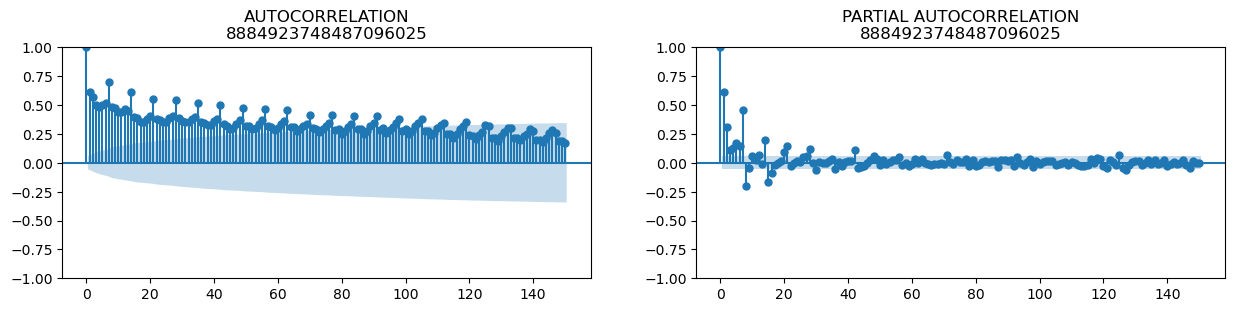

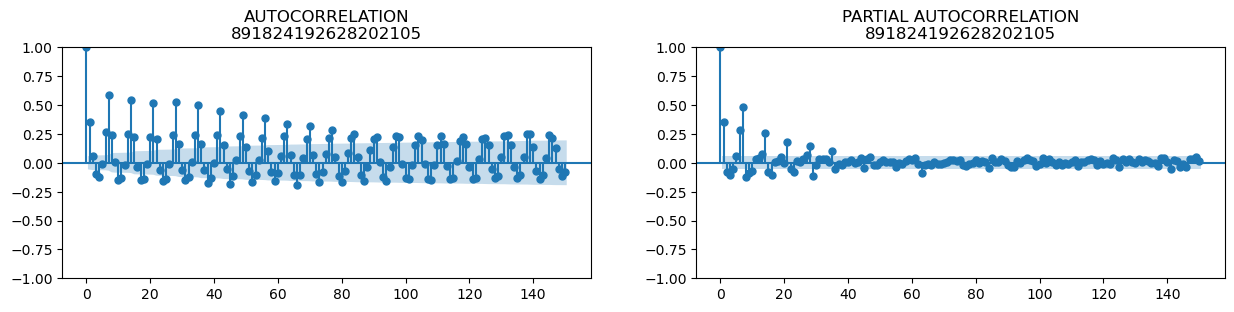

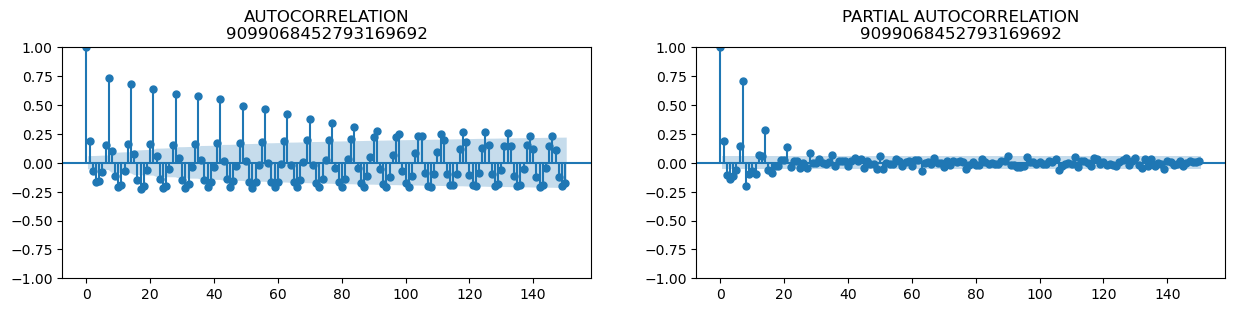

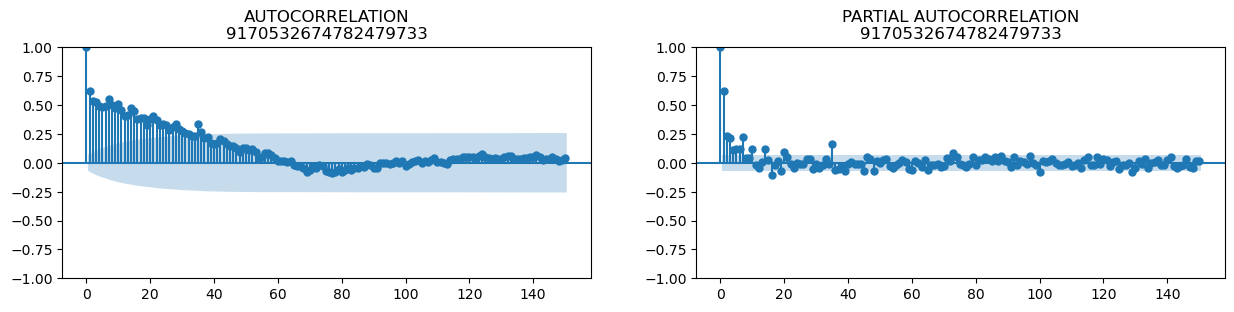

In [110]:
df_analyze = df[(df["Ventes"].notnull())].groupby([feat_date, "id"])["Ventes"].mean().reset_index().set_index(feat_date)
for num, i in enumerate(df_analyze["id"].unique()):
    try:
        fig, ax = plt.subplots(1,2,figsize=(15,3))
        temp = df_analyze[(df_analyze["id"] == i)]
        sm.graphics.tsa.plot_acf(temp["Ventes"], lags=150, ax=ax[0], title = "AUTOCORRELATION\n" + i)
        sm.graphics.tsa.plot_pacf(temp["Ventes"], lags=150, ax=ax[1], title = "PARTIAL AUTOCORRELATION\n" + i)
    except:
        pass

Focus on the PACF for the top seller in order to have a clearer view

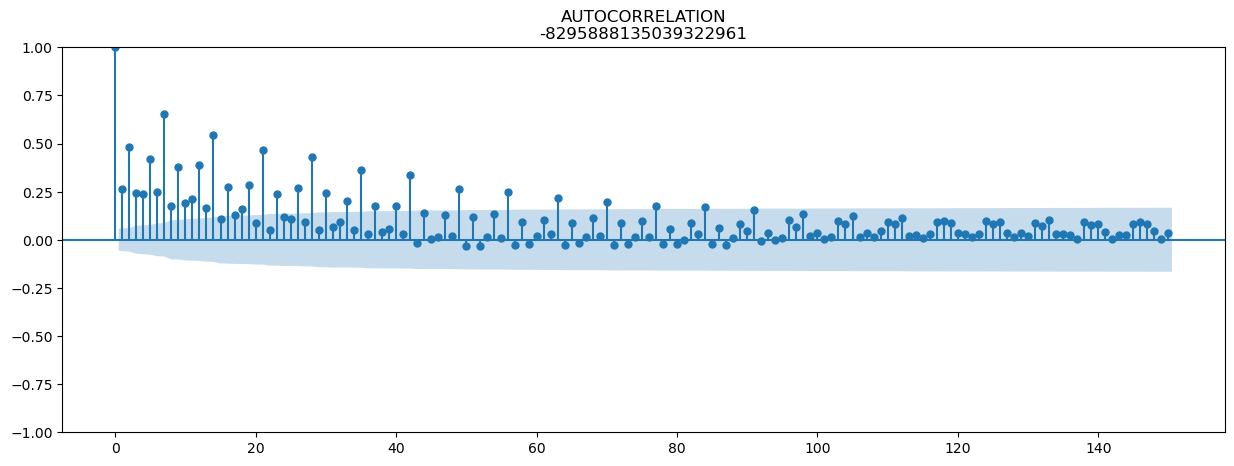

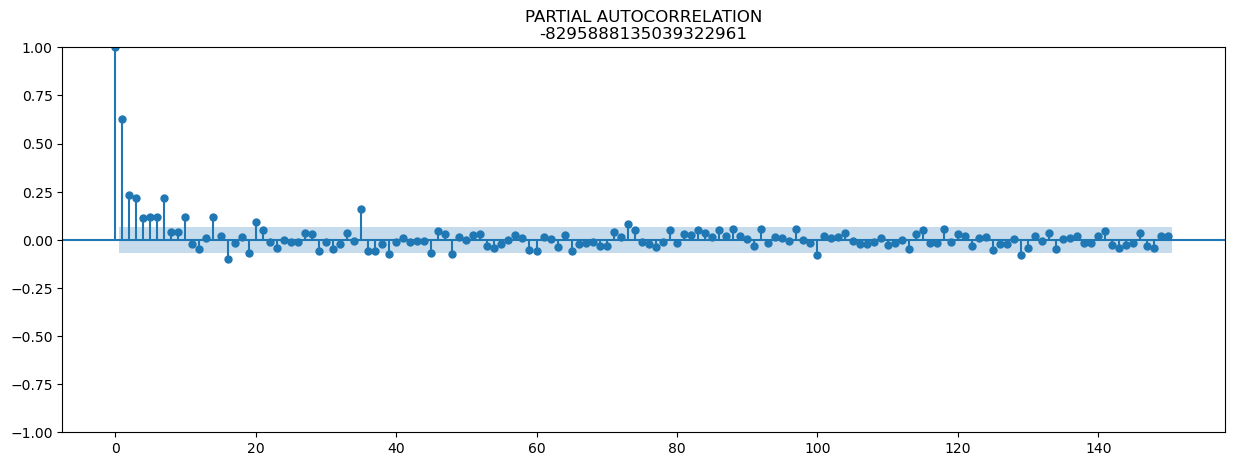

In [111]:
top_id = "-8295888135039322961"

df_analyze_id = df[(df["Ventes"].notnull()) & (df["id"] == top_id)].groupby([feat_date])["Ventes"].mean().reset_index().set_index(feat_date)
fig, ax = plt.subplots(figsize=(15,5))
sm.graphics.tsa.plot_acf(df_analyze_id["Ventes"], lags=150, ax=ax, title = "AUTOCORRELATION\n" + top_id)
plt.show()

fig, ax = plt.subplots(figsize=(15,5))
sm.graphics.tsa.plot_pacf(temp["Ventes"], lags=150, ax=ax, title = "PARTIAL AUTOCORRELATION\n" + top_id)
plt.show()

Looking at the PACF plot, select the following lags to try for the model: 1, 2, 3, 4, 5, 6, 7, 10, 13, 15, 34

As we consider we should decide two weeks before, our lag should start at least 14.

In [112]:
lags_to_try = [1, 2, 3, 4, 5, 6, 7, 10, 13, 15, 34]

# 5. Split the dataset into train and test

For the split, we choose to leave one week as we consider it might be the time needed to prepare everything (order ressources to print, order the right amount for delivery, etc.). Of course, this choice is arbitrary and might need to be changed depending on the customer.

In [113]:
# Relod dataset
df = pd.read_csv(os.path.join(path_data, "dataset.gz"), sep=";")

# Set type
df = set_type(df, feat_date="Date")
# Add lags seen
df = add_lags_sma(df, lags_to_try, feat_id='id')
# Split into train and test
df_train, df_test, y_train, y_test = split_train_test(df=df, feat_date="Date")
check_split(df_train, df_test, feat_date)

# Save
path_save = '../data/processed'
df_train.to_pickle(os.path.join(path_save, "train.pkl"))
df_test.to_pickle(os.path.join(path_save, "test.pkl"))
y_train.to_csv(os.path.join(path_save, "target_train.csv"))
y_test.to_csv(os.path.join(path_save, "target_test.csv"))

Train: 2020-01-02 00:00:00 2023-04-02 00:00:00
Test: 2023-04-03 00:00:00 2023-04-17 00:00:00
Ind in both train and test: []


/Users/benjaminwallyn/Documents/Git/demand-forecast/notebooks/../src/prepare_data.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns="Ventes", inplace=True)
/Users/benjaminwallyn/Documents/Git/demand-forecast/notebooks/../src/prepare_data.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns="Ventes", inplace=True)
